<a href="https://colab.research.google.com/github/Sathish1505/MBE_Simulator/blob/main/Material_Balance_Simulator_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gas Reservoir**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
from scipy.optimize import brentq
from sklearn.linear_model import LinearRegression

# -----------------------------------------------------
# Function: Calculate Bw using McCain's correlation
# -----------------------------------------------------
def calculate_Bw(res_p, t):
    delta_VwP = (-1.95301e-9 * res_p * t
                 - 1.72834e-13 * (res_p**2) * t
                 - 3.58922e-7 * res_p
                 - 2.25341e-10 * (res_p**2))
    delta_VwT = (-1.0001e-2
                 + 1.33391e-4 * t
                 + 5.50654e-7 * (t**2))
    Bw = (1 + delta_VwP) * (1 + delta_VwT)
    return Bw

# -----------------------------------------------------
# Function: Compute Z Factor using Newton-Raphson method
# -----------------------------------------------------
def compute_z(Sg, p_val, t):
    T_pc = 120.1 + 425 * Sg - 62.9 * (Sg**2)
    P_pc = 671.1 + 14 * Sg - 34.3 * (Sg**2)
    T_pr = (t + 460) / T_pc
    P_pr = p_val / P_pc
    Z = 1.0
    tol = 1e-6
    for _ in range(100):
        rho_r = 0.27 * P_pr / (Z * T_pr)
        term1 = (0.3265 - 1.07/T_pr - 0.5339/(T_pr**3) + 0.01569/(T_pr**4) - 0.05165/(T_pr**5)) * rho_r
        term2 = (0.5475 - 0.7361/T_pr + 0.1844/(T_pr**2)) * (rho_r**2)
        term3 = -0.1056 * ((-0.7361/T_pr) + (0.1844/(T_pr**2))) * (rho_r**5)
        term4 = 0.6134 * (1 + 0.7210*(rho_r**2)) * ((rho_r**2)/(T_pr**3)) * np.exp(-0.7210*(rho_r**2))
        F_val = 1 + term1 + term2 + term3 + term4
        f_Z = Z - F_val
        delta = 1e-6
        Z_plus = Z + delta
        rho_r_plus = 0.27 * P_pr / (Z_plus * T_pr)
        term1_plus = (0.3265 - 1.07/T_pr - 0.5339/(T_pr**3) + 0.01569/(T_pr**4) - 0.05165/(T_pr**5)) * rho_r_plus
        term2_plus = (0.5475 - 0.7361/T_pr + 0.1844/(T_pr**2)) * (rho_r_plus**2)
        term3_plus = -0.1056 * ((-0.7361/T_pr) + (0.1844/(T_pr**2))) * (rho_r_plus**5)
        term4_plus = 0.6134 * (1 + 0.7210*(rho_r_plus**2)) * ((rho_r_plus**2)/(T_pr**3)) * np.exp(-0.7210*(rho_r_plus**2))
        F_plus = 1 + term1_plus + term2_plus + term3_plus + term4_plus
        f_Z_plus = Z_plus - F_plus
        Z_minus = Z - delta
        rho_r_minus = 0.27 * P_pr / (Z_minus * T_pr)
        term1_minus = (0.3265 - 1.07/T_pr - 0.5339/(T_pr**3) + 0.01569/(T_pr**4) - 0.05165/(T_pr**5)) * rho_r_minus
        term2_minus = (0.5475 - 0.7361/T_pr + 0.1844/(T_pr**2)) * (rho_r_minus**2)
        term3_minus = -0.1056 * ((-0.7361/T_pr) + (0.1844/(T_pr**2))) * (rho_r_minus**5)
        term4_minus = 0.6134 * (1 + 0.7210*(rho_r_minus**2)) * ((rho_r_minus**2)/(T_pr**3)) * np.exp(-0.7210*(rho_r_minus**2))
        F_minus = 1 + term1_minus + term2_minus + term3_minus + term4_minus
        f_Z_minus = Z_minus - F_minus
        derivative = (f_Z_plus - f_Z_minus) / (2 * delta)
        if abs(derivative) < 1e-12:
            break
        Z_new = Z - f_Z / derivative
        if abs(Z_new - Z) < tol:
            Z = Z_new
            break
        Z = Z_new
    return Z

# -----------------------------------------------------
# Function: Calculate Gas Viscosity using Lee et al.
# -----------------------------------------------------
def calculate_gas_viscosity(p, t, sg_g, Z):
    M = 28.97 * sg_g
    rho_g = (28.97 * sg_g * p) / (Z * 10.73 * (t + 460))
    K = ((9.4 + 0.02 * M) * ((t + 460)**1.5)) / (209 + 19 * M + t + 460)
    X = 3.5 + (986 / (t + 460)) + 0.01 * M
    Y = 2.4 - 0.2 * X
    viscosity = 1e-4 * K * np.exp(X * ((rho_g / 62.4)**Y))
    return viscosity


In [ ]:
# -----------------------------------------------------
# Historical Inputs and Data Loading (Gas Reservoir)
# -----------------------------------------------------
res_p = float(input("Enter reservoir pressure (psi): "))
t = int(input("Enter temperature (F): "))
sg_g = float(input("Enter gas specific gravity: "))
c_f = float(input("Enter rock compressibility (1/psi): "))
c_w = float(input("Enter water compressibility (1/psi): "))
S_wc = float(input("Enter initial water saturation (fraction): "))

Enter reservoir pressure (psi): 5300
Enter temperature (F): 200
Enter gas specific gravity: 0.7
Enter rock compressibility (1/psi): 0.000005
Enter water compressibility (1/psi): 0.000003
Enter initial water saturation (fraction): 0.2


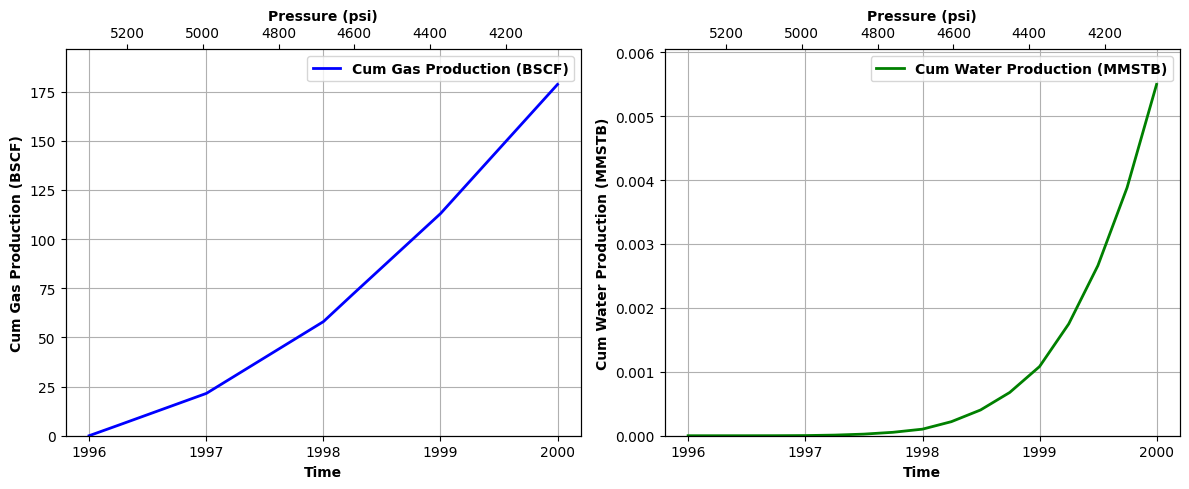

In [ ]:
# -----------------------------------------------------
# Load Production Data from Excel
# -----------------------------------------------------

# Load data
history_data = pd.read_excel('GAS.xls')
dates = pd.to_datetime(history_data['Date'])
pressure_data = history_data['Pressure'].values
Gp_data = history_data['Cum Gas Production'].values  # In BSCF
Wp_data = history_data.get('Cum Water Production', np.zeros(len(pressure_data))).values  # In MMSTB
n_points = len(pressure_data)

# Plot all production data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for cumulative gas production
ax1.plot(dates, Gp_data, 'b-', linewidth=2, label='Cum Gas Production (BSCF)')
ax1.set_xlabel('Time', fontweight='bold')
ax1.set_ylabel('Cum Gas Production (BSCF)', fontweight='bold')
ax1.set_ylim(min(Gp_data) * 0.9, max(Gp_data) * 1.1)
ax1.legend(prop={'weight':'bold'})
ax1.grid()
ax1_twin = ax1.twiny()
ax1_twin.plot(pressure_data, Gp_data, 'r--', linewidth=2, alpha=0)
ax1_twin.set_xlabel('Pressure (psi)', fontweight='bold')
ax1_twin.invert_xaxis()

# Plot for cumulative water production
ax2.plot(dates, Wp_data, 'g-', linewidth=2, label='Cum Water Production (MMSTB)')
ax2.set_xlabel('Time', fontweight='bold')
ax2.set_ylabel('Cum Water Production (MMSTB)', fontweight='bold')
ax2.set_ylim(min(Wp_data) * 0.9, max(Wp_data) * 1.1)
ax2.legend(prop={'weight':'bold'})
ax2.grid()
ax2_twin = ax2.twiny()
ax2_twin.plot(pressure_data, Wp_data, 'r--', linewidth=2, alpha=0)
ax2_twin.set_xlabel('Pressure (psi)', fontweight='bold')
ax2_twin.invert_xaxis()

# Set x-axis to show only years
ax1.xaxis.set_major_locator(YearLocator())
ax1.xaxis.set_major_formatter(DateFormatter('%Y'))
ax2.xaxis.set_major_locator(YearLocator())
ax2.xaxis.set_major_formatter(DateFormatter('%Y'))

plt.tight_layout()
plt.show()

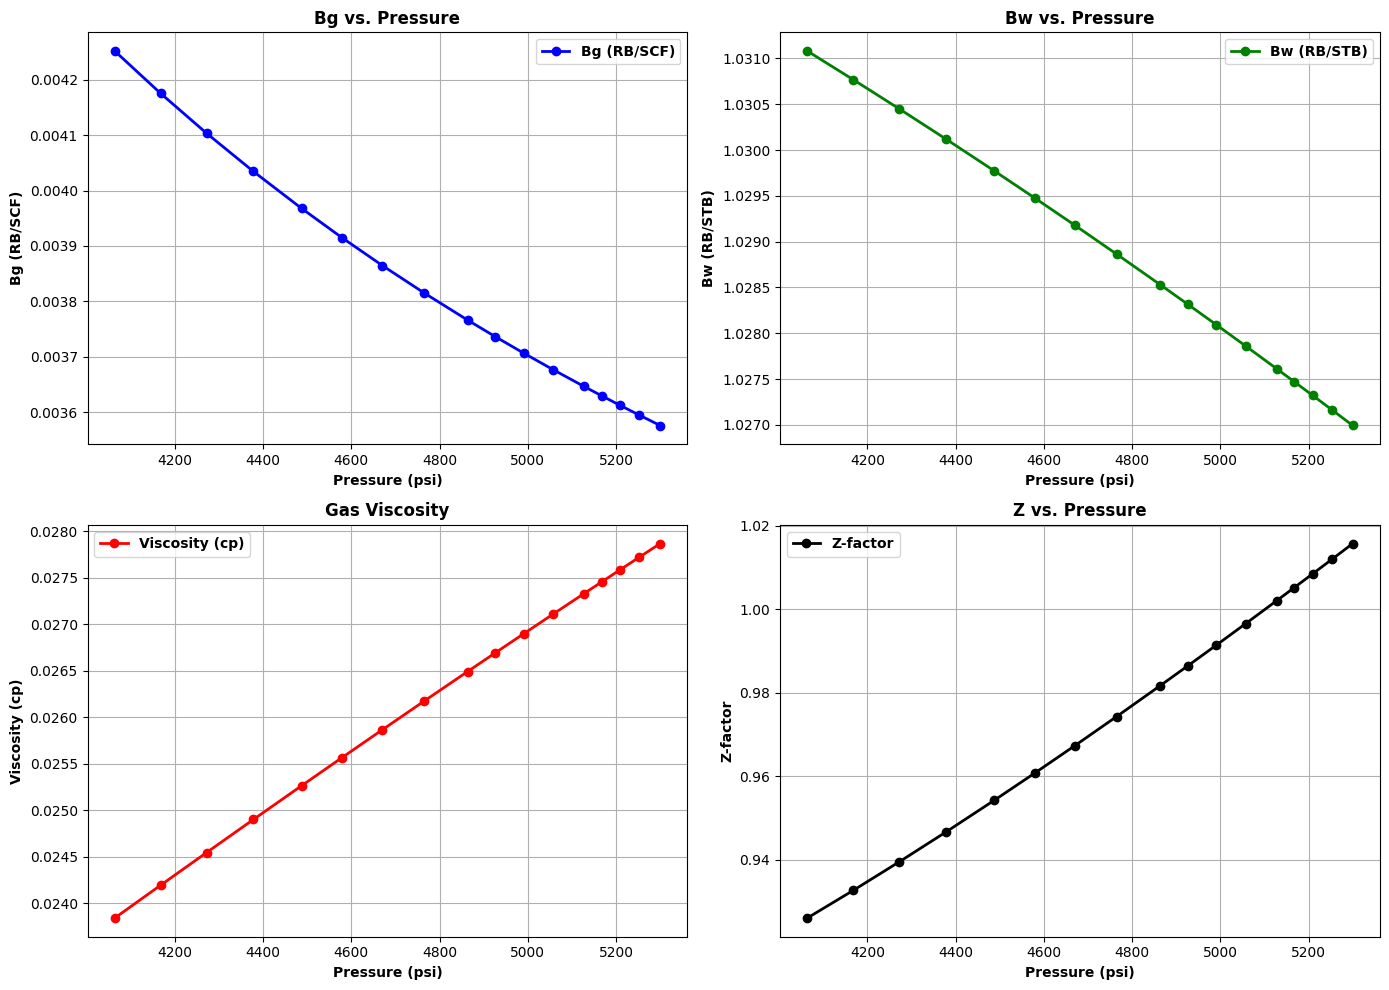

In [ ]:
# -----------------------------------------------------
# Calculate Fluid Properties for Gas Reservoir
# -----------------------------------------------------
Z_prod = np.zeros(n_points)
Bg_data = np.zeros(n_points)
Bw_data = np.zeros(n_points)
for i in range(n_points):
    Z_prod[i] = compute_z(sg_g, pressure_data[i], t)
    Bg_data[i] = 0.02827 * Z_prod[i] * (t + 460) / pressure_data[i]
    Bw_data[i] = calculate_Bw(pressure_data[i], t)
B_gi = Bg_data[0]

# Compute Gas Viscosity
viscosity_data = np.array([calculate_gas_viscosity(p, t, sg_g, Z) for p, Z in zip(pressure_data, Z_prod)])

# -----------------------------------------------------
# Fluid Properties Plots (2x2 Grid)
# -----------------------------------------------------
fig_fp, axs = plt.subplots(2, 2, figsize=(14,10))
axs[0,0].plot(pressure_data, Bg_data, 'b-o', linewidth=2, label='Bg (RB/SCF)')
axs[0,0].set_xlabel('Pressure (psi)', fontweight='bold')
axs[0,0].set_ylabel('Bg (RB/SCF)', fontweight='bold')
axs[0,0].set_title('Bg vs. Pressure', fontweight='bold')
axs[0,0].legend(prop={'weight':'bold'})
axs[0,0].grid()

axs[0,1].plot(pressure_data, Bw_data, 'g-o', linewidth=2, label='Bw (RB/STB)')
axs[0,1].set_xlabel('Pressure (psi)', fontweight='bold')
axs[0,1].set_ylabel('Bw (RB/STB)', fontweight='bold')
axs[0,1].set_title('Bw vs. Pressure', fontweight='bold')
axs[0,1].legend(prop={'weight':'bold'})
axs[0,1].grid()

axs[1,0].plot(pressure_data, viscosity_data, 'r-o', linewidth=2, label='Viscosity (cp)')
axs[1,0].set_xlabel('Pressure (psi)', fontweight='bold')
axs[1,0].set_ylabel('Viscosity (cp)', fontweight='bold')
axs[1,0].set_title('Gas Viscosity', fontweight='bold')
axs[1,0].legend(prop={'weight':'bold'})
axs[1,0].grid()

axs[1,1].plot(pressure_data, Z_prod, 'k-o', linewidth=2, label='Z-factor')
axs[1,1].set_xlabel('Pressure (psi)', fontweight='bold')
axs[1,1].set_ylabel('Z-factor', fontweight='bold')
axs[1,1].set_title('Z vs. Pressure', fontweight='bold')
axs[1,1].legend(prop={'weight':'bold'})
axs[1,1].grid()

plt.tight_layout()
plt.show()

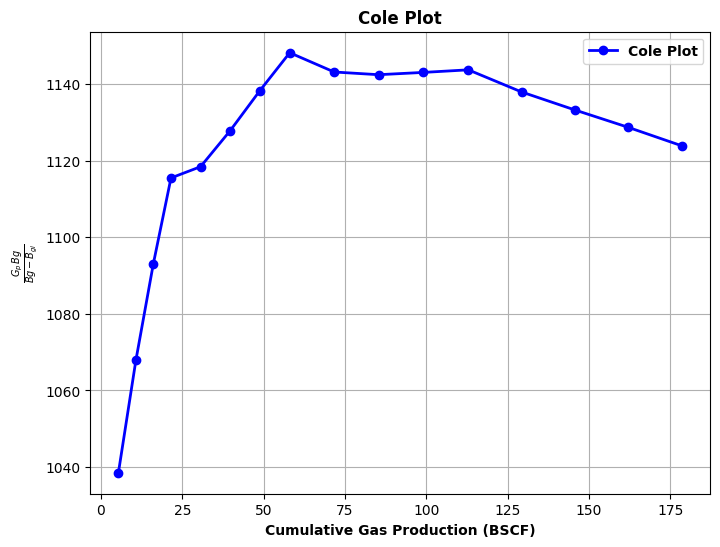

In [ ]:
# -----------------------------------------------------
# Cole Plot Calculation (for Water Influx Identification)
# -----------------------------------------------------
cole_y = np.full(n_points, np.nan)
for i in range(1, n_points):
    if Bg_data[i] != B_gi:
        cole_y[i] = Gp_data[i] * Bg_data[i] / (Bg_data[i] - B_gi)
plt.figure(figsize=(8,6))
plt.plot(Gp_data[1:], cole_y[1:], 'bo-', linewidth=2, label='Cole Plot')
plt.xlabel('Cumulative Gas Production (BSCF)', fontweight='bold')
plt.ylabel(r'$\frac{G_p\,Bg}{Bg - B_{gi}}$', fontweight='bold')
plt.title('Cole Plot', fontweight='bold')
plt.legend(prop={'weight':'bold'})
plt.grid()
plt.show()


Is water influx present? (yes/no): yes
Enter Aquifer Volume (MMft^3): 300


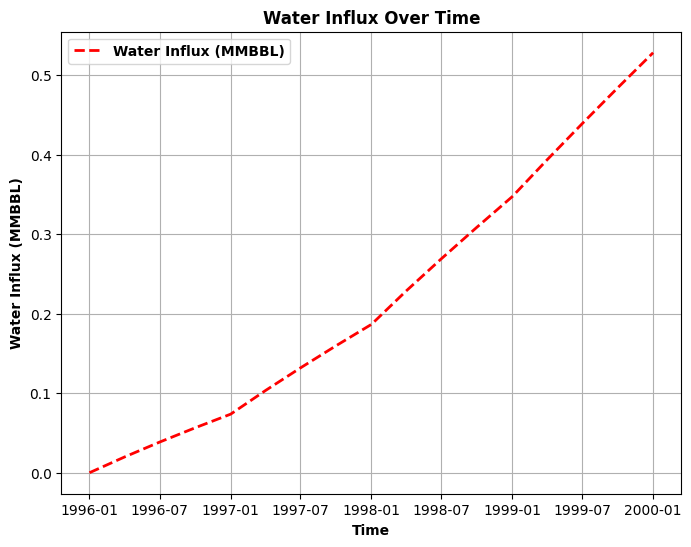

In [ ]:
# -----------------------------------------------------
# Calculate Water Influx using Pot Aquifer Method
# -----------------------------------------------------
influx_present = input("Is water influx present? (yes/no): ").strip().lower() == 'yes'
if influx_present:
    W_ei = float(input("Enter Aquifer Volume (MMft^3): "))
    c_t_total = c_w + c_f
    We_data = np.zeros(n_points)
    for i in range(n_points):
        delta_P = res_p - pressure_data[i]
        We_data[i] = (W_ei / 5.615) * c_t_total * delta_P
    plt.figure(figsize=(8,6))
    plt.plot(dates, We_data, 'r--', linewidth=2, label='Water Influx (MMBBL)')
    plt.xlabel('Time', fontweight='bold')
    plt.ylabel('Water Influx (MMBBL)', fontweight='bold')
    plt.title('Water Influx Over Time', fontweight='bold')
    plt.legend(prop={'weight':'bold'})
    plt.grid()
    plt.show()
else:
    We_data = np.zeros(n_points)

<ipython-input-8-ff5ed05cf3c6>:27: RuntimeWarning: invalid value encountered in divide
  ratio = (F_data - We_data) / E_t_data


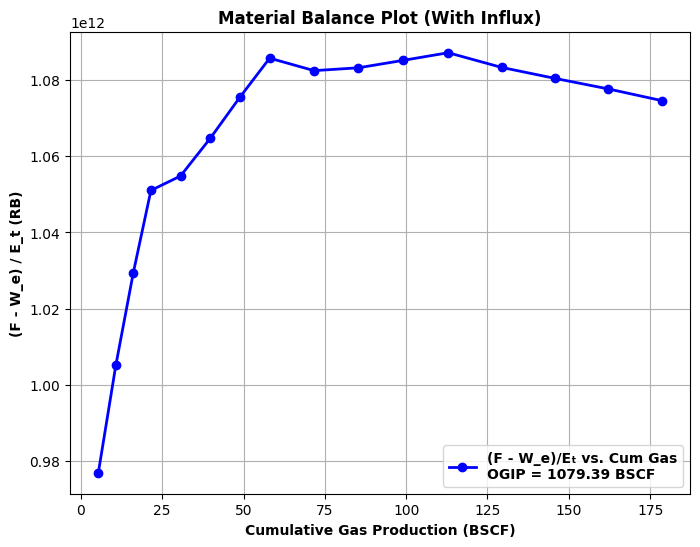

Estimated OGIP (With Influx): 1079.39 BSCF


In [ ]:
# -----------------------------------------------------
# Material Balance Plot for OGIP Estimation
# -----------------------------------------------------
F_data = (Gp_data * 1e9) * Bg_data + (Wp_data * 1e6) * Bw_data  # Gp in SCF, Wp in STB
C = (c_f + c_w * S_wc) / (1 - S_wc)
E_t_data = (Bg_data - B_gi) + B_gi * C * (res_p - pressure_data)
numerator = np.sum(E_t_data * F_data)
denom = np.sum(E_t_data**2)
if denom == 0:
    raise ValueError("Zero variance in expansion term.")
G_intercept_SCF = numerator / denom  # G_intercept in SCF
G_intercept = G_intercept_SCF / 1e9  # Convert to BSCF

if not influx_present:
    ratio = F_data / E_t_data
    plt.figure(figsize=(8,6))
    plt.plot(Gp_data, ratio, 'bo-', linewidth=2,
             label=f'F/Eₜ vs. Cum Gas\nOGIP = {G_intercept:.2f} BSCF')
    plt.xlabel('Cumulative Gas Production (BSCF)', fontweight='bold')
    plt.ylabel('F / E_t (RB)', fontweight='bold')
    plt.title('Material Balance Plot (No Influx)', fontweight='bold')
    plt.legend(prop={'weight':'bold'})
    plt.grid()
    plt.show()
    print(f"Estimated OGIP (No Influx): {G_intercept:.2f} BSCF")
else:
    ratio = (F_data - We_data) / E_t_data
    plt.figure(figsize=(8,6))
    plt.plot(Gp_data, ratio, 'bo-', linewidth=2,
             label=f'(F - W_e)/Eₜ vs. Cum Gas\nOGIP = {G_intercept:.2f} BSCF')
    plt.xlabel('Cumulative Gas Production (BSCF)', fontweight='bold')
    plt.ylabel('(F - W_e) / E_t (RB)', fontweight='bold')
    plt.title('Material Balance Plot (With Influx)', fontweight='bold')
    plt.legend(prop={'weight':'bold'})
    plt.grid()
    plt.show()
    print(f"Estimated OGIP (With Influx): {G_intercept:.2f} BSCF")

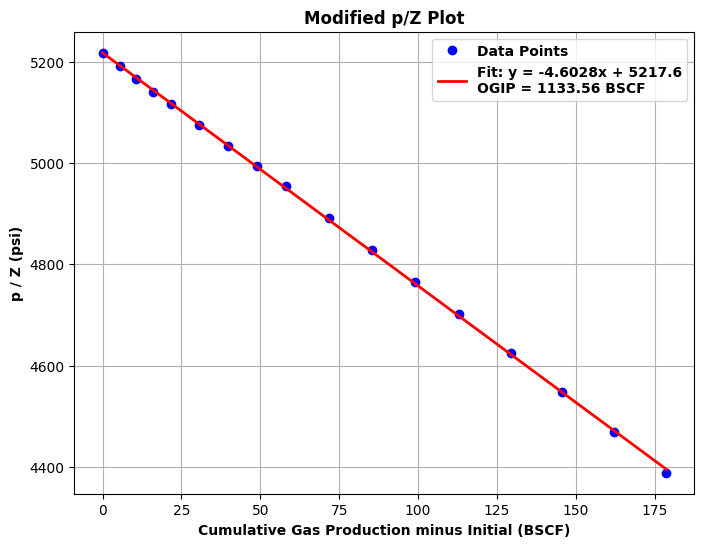

In [ ]:
# -----------------------------------------------------
# Modified p/Z Plot for OGIP Estimation
# -----------------------------------------------------
G_initial = Gp_data[0]
x_modified = Gp_data - G_initial
y_modified = pressure_data / Z_prod
model = LinearRegression()
model.fit(x_modified.reshape(-1, 1), y_modified)
slope_val = model.coef_[0]
intercept_val = model.intercept_
OGIP_estimated = intercept_val / -slope_val  # In BSCF

plt.figure(figsize=(8,6))
plt.plot(x_modified, y_modified, 'bo', linewidth=2, label='Data Points')
x_fit = np.linspace(min(x_modified), max(x_modified), 100)
y_fit = model.predict(x_fit.reshape(-1, 1))
plt.plot(x_fit, y_fit, 'r-', linewidth=2,
         label=f'Fit: y = {slope_val:.4f}x + {intercept_val:.1f}\nOGIP = {OGIP_estimated:.2f} BSCF')
plt.xlabel('Cumulative Gas Production minus Initial (BSCF)', fontweight='bold')
plt.ylabel('p / Z (psi)', fontweight='bold')
plt.title('Modified p/Z Plot', fontweight='bold')
plt.legend(prop={'weight':'bold'})
plt.grid()
plt.show()

<ipython-input-10-71ec00da2263>:9: RuntimeWarning: invalid value encountered in divide
  gas_exp_pct = np.nan_to_num((E_g_drive / total_expansion_drive) * 100)
<ipython-input-10-71ec00da2263>:10: RuntimeWarning: invalid value encountered in divide
  rock_water_pct = np.nan_to_num((E_fw_drive / total_expansion_drive) * 100)
<ipython-input-10-71ec00da2263>:11: RuntimeWarning: invalid value encountered in divide
  water_influx_pct = np.nan_to_num((We_term_drive / total_expansion_drive) * 100)


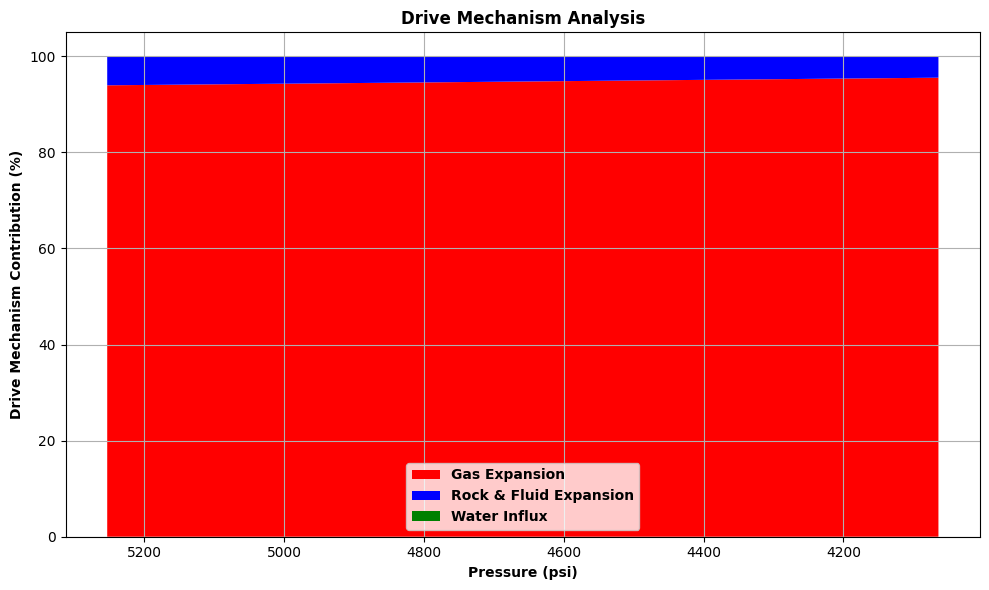

In [ ]:
# -----------------------------------------------------
# Drive Mechanism Analysis
# -----------------------------------------------------
E_g_drive = Bg_data - B_gi
C_val = (c_f + c_w * S_wc) / (1 - S_wc)
E_fw_drive = B_gi * C_val * (res_p - pressure_data)
We_term_drive = We_data / (G_intercept * 1e3) if G_intercept != 0 else np.zeros_like(We_data)
total_expansion_drive = E_g_drive + E_fw_drive + We_term_drive
gas_exp_pct = np.nan_to_num((E_g_drive / total_expansion_drive) * 100)
rock_water_pct = np.nan_to_num((E_fw_drive / total_expansion_drive) * 100)
water_influx_pct = np.nan_to_num((We_term_drive / total_expansion_drive) * 100)

plot_pressure = pressure_data[1:]
plot_gas_pct = gas_exp_pct[1:]
plot_rock_pct = rock_water_pct[1:]
plot_water_pct = water_influx_pct[1:]

plt.figure(figsize=(10,6))
plt.stackplot(plot_pressure, plot_gas_pct, plot_rock_pct, plot_water_pct,
              labels=['Gas Expansion', 'Rock & Fluid Expansion', 'Water Influx'],
              colors=['red', 'blue', 'green'], linewidth=2)
plt.xlabel('Pressure (psi)', fontweight='bold')
plt.ylabel('Drive Mechanism Contribution (%)', fontweight='bold')
plt.title('Drive Mechanism Analysis', fontweight='bold')
plt.legend(prop={'weight':'bold'})
plt.grid(True)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

## **Future Prediction**

In [ ]:
# -----------------------------------------------------
# Future Prediction
# -----------------------------------------------------
def material_balance(p, Gp_BSCF, Wp_MMSTB, G_BSCF, W_ei, c_t, influx_present):
    Z = compute_z(sg_g, p, t)
    Bg = 0.02827 * Z * (t + 460) / p  # RB/SCF
    Bw = calculate_Bw(p, t)  # RB/STB
    F = (Gp_BSCF * 1e9) * Bg + (Wp_MMSTB * 1e6) * Bw  # RB
    E_g = Bg - B_gi
    C = (c_f + c_w * S_wc) / (1 - S_wc)
    E_fw = B_gi * C * (res_p - p)
    E_t = E_g + E_fw  # RB/SCF
    if influx_present:
        W_e = (W_ei / 5.615) * c_t * (res_p - p)  # RB
    else:
        W_e = 0
    return F - (G_BSCF * 1e9) * E_t - W_e

# Step 1: Calculate average cumulative flow rates
Gp_data_SCF = Gp_data * 1e9  # BSCF -> SCF
Wp_data_STB = Wp_data * 1e6  # MMSTB -> STB
time_days = (dates - dates.iloc[0]).dt.days
time_diffs_days = np.diff(time_days)
q_g = np.diff(Gp_data_SCF) / time_diffs_days
q_w = np.diff(Wp_data_STB) / time_diffs_days
q_g_avg = np.mean(q_g)  # SCF/day
q_w_avg = np.mean(q_w)  # STB/day
print(f"Average Gas Flow Rate: {q_g_avg:.2f} SCF/day")
print(f"Average Water Flow Rate: {q_w_avg:.2f} STB/day")

Average Gas Flow Rate: 122314085.14 SCF/day
Average Water Flow Rate: 3.76 STB/day


In [ ]:
# Step 2: Specify future prediction date
future_date_str = input("Enter future date (YYYY-MM-DD): ")
future_date = pd.to_datetime(future_date_str)
last_date = dates.iloc[-1]
if future_date <= last_date:
    raise ValueError("Future date must be after the last historical date.")
future_dates = pd.date_range(start=last_date, end=future_date, freq='MS')
if future_dates[0] != last_date:
    future_dates = np.insert(future_dates, 0, last_date)
time_to_future_days = (future_dates - last_date).days

# Step 3: Calculate future cumulative productions
G_BSCF = G_intercept  # OGIP in BSCF
G_SCF = G_BSCF * 1e9  # Convert OGIP to SCF
Gp_future = []
Wp_future = []
valid_future_dates = []
for dt, f_date in zip(time_to_future_days, future_dates):
    Gp_temp = Gp_data_SCF[-1] + q_g_avg * dt
    if Gp_temp > G_SCF:
        break
    Wp_temp = Wp_data_STB[-1] + q_w_avg * dt
    Gp_future.append(Gp_temp / 1e9)  # Convert back to BSCF
    Wp_future.append(Wp_temp / 1e6)  # Convert back to MMSTB
    valid_future_dates.append(f_date)
Gp_future = np.array(Gp_future)  # In BSCF
Wp_future = np.array(Wp_future)  # In MMSTB
future_dates = valid_future_dates

Enter future date (YYYY-MM-DD): 2010-01-01


In [ ]:
# Step 4: Back-calculate pressure
pressure_future = np.zeros(len(future_dates))
for i, (Gp_val, Wp_val) in enumerate(zip(Gp_future, Wp_future)):
    def f(p):
        return material_balance(p, Gp_val, Wp_val, G_BSCF, W_ei if influx_present else 0, c_t_total if influx_present else 0, influx_present)
    try:
        pressure_future[i] = brentq(f, 100, res_p, xtol=1e-6, maxiter=100)
    except ValueError:
        print(f"Warning: No solution found for date {future_dates[i]}. Using previous pressure value.")
        pressure_future[i] = pressure_future[i-1] if i > 0 else pressure_data[-1]

# Step 5: Calculate future fluid properties
Z_future = np.array([compute_z(sg_g, p, t) for p in pressure_future])
Bg_future = 0.02827 * Z_future * (t + 460) / pressure_future
Bw_future = np.array([calculate_Bw(p, t) for p in pressure_future])
viscosity_future = np.array([calculate_gas_viscosity(p, t, sg_g, z) for p, z in zip(pressure_future, Z_future)])

# Combine historical and future data
all_dates = pd.to_datetime(np.append(dates, future_dates))
all_pressure = np.append(pressure_data, pressure_future)
all_Gp = np.append(Gp_data, Gp_future)  # In BSCF
all_Wp = np.append(Wp_data, Wp_future)  # In MMSTB
all_Bg = np.append(Bg_data, Bg_future)
all_Bw = np.append(Bw_data, Bw_future)
all_viscosity = np.append(viscosity_data, viscosity_future)
all_Z = np.append(Z_prod, Z_future)

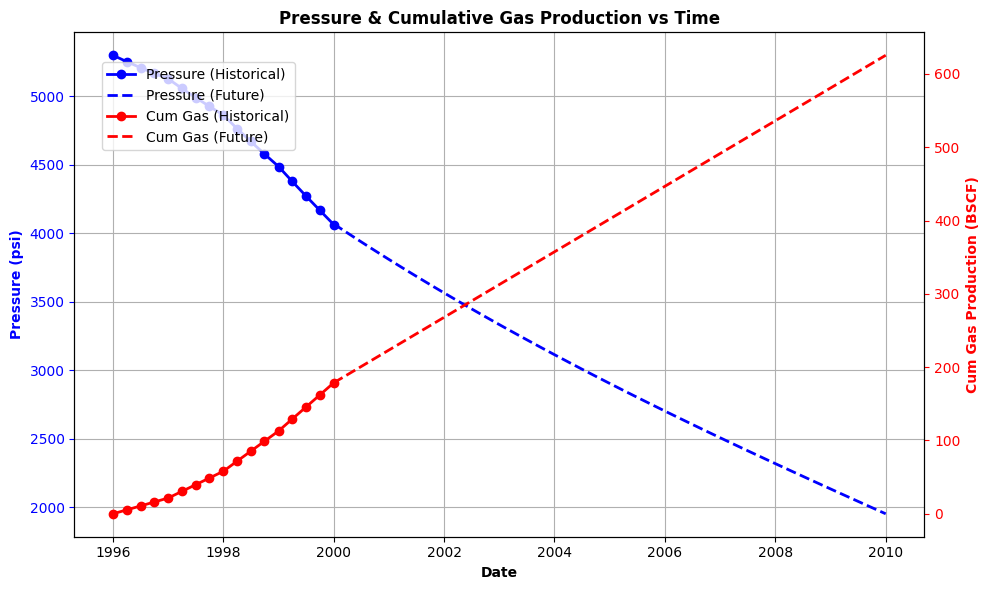

In [ ]:
# Plot Pressure & Cumulative Gas vs Time
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(all_dates[:len(dates)], all_pressure[:len(dates)], 'b-o', linewidth=2, label='Pressure (Historical)')
ax1.plot(future_dates, pressure_future, 'b--', linewidth=2, label='Pressure (Future)')
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('Pressure (psi)', color='b', fontweight='bold')
ax1.tick_params(axis='y', colors='b')
ax1.grid()
ax2 = ax1.twinx()
ax2.plot(all_dates[:len(dates)], all_Gp[:len(dates)], 'r-o', linewidth=2, label='Cum Gas (Historical)')
ax2.plot(future_dates, Gp_future, 'r--', linewidth=2, label='Cum Gas (Future)')
ax2.set_ylabel('Cum Gas Production (BSCF)', color='r', fontweight='bold')
ax2.tick_params(axis='y', colors='r')
plt.title('Pressure & Cumulative Gas Production vs Time', fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.tight_layout()
plt.show()

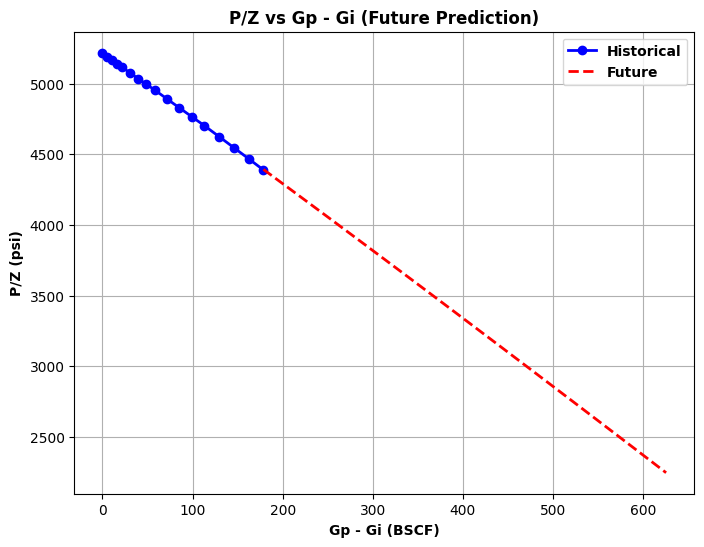

In [ ]:
# Plot P/Z vs Gp - Gi (Future Prediction)
all_Gp_minus_Gi = all_Gp - G_initial
all_P_over_Z = all_pressure / all_Z
plt.figure(figsize=(8,6))
plt.plot(all_Gp_minus_Gi[:len(dates)], all_P_over_Z[:len(dates)], 'bo-', linewidth=2, label='Historical')
plt.plot(all_Gp_minus_Gi[len(dates):], all_P_over_Z[len(dates):], 'r--', linewidth=2, label='Future')
plt.xlabel('Gp - Gi (BSCF)', fontweight='bold')
plt.ylabel('P/Z (psi)', fontweight='bold')
plt.title('P/Z vs Gp - Gi (Future Prediction)', fontweight='bold')
plt.legend(prop={'weight':'bold'})
plt.grid()
plt.show()


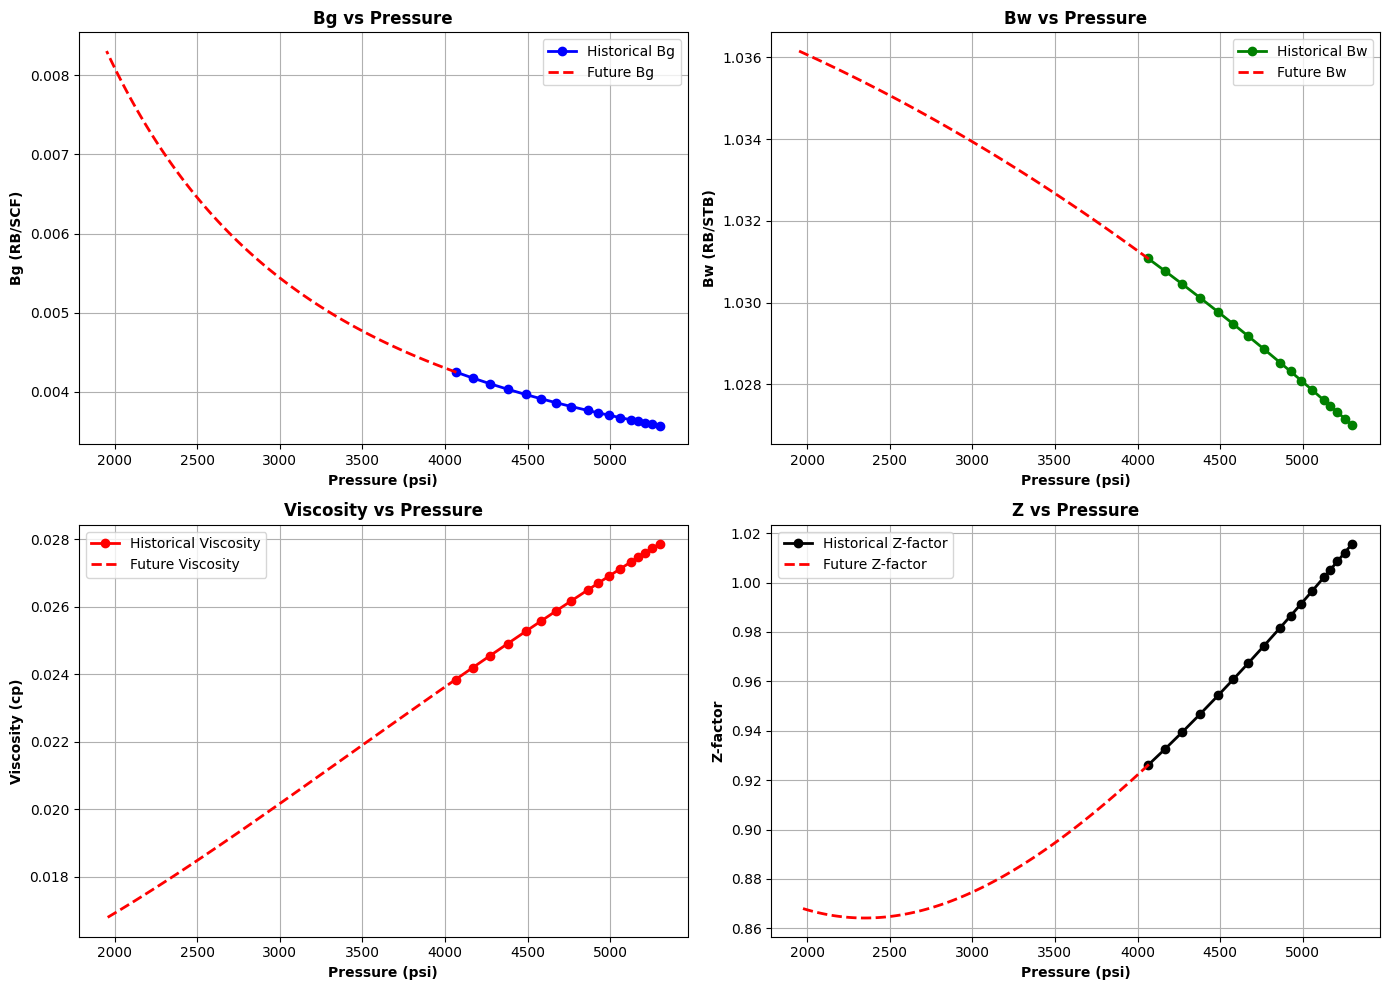

In [ ]:
# Plot Future Fluid Property Trends vs Pressure
fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs[0,0].plot(all_pressure[:len(pressure_data)], all_Bg[:len(pressure_data)], 'b-o', linewidth=2, label='Historical Bg')
axs[0,0].plot(all_pressure[len(pressure_data):], all_Bg[len(pressure_data):], 'r--', linewidth=2, label='Future Bg')
axs[0,0].set_xlabel('Pressure (psi)', fontweight='bold'); axs[0,0].set_ylabel('Bg (RB/SCF)', fontweight='bold')
axs[0,0].set_title('Bg vs Pressure', fontweight='bold'); axs[0,0].legend(); axs[0,0].grid()
axs[0,1].plot(all_pressure[:len(pressure_data)], all_Bw[:len(pressure_data)], 'g-o', linewidth=2, label='Historical Bw')
axs[0,1].plot(all_pressure[len(pressure_data):], all_Bw[len(pressure_data):], 'r--', linewidth=2, label='Future Bw')
axs[0,1].set_xlabel('Pressure (psi)', fontweight='bold'); axs[0,1].set_ylabel('Bw (RB/STB)', fontweight='bold')
axs[0,1].set_title('Bw vs Pressure', fontweight='bold'); axs[0,1].legend(); axs[0,1].grid()
axs[1,0].plot(all_pressure[:len(pressure_data)], all_viscosity[:len(pressure_data)], 'r-o', linewidth=2, label='Historical Viscosity')
axs[1,0].plot(all_pressure[len(pressure_data):], all_viscosity[len(pressure_data):], 'r--', linewidth=2, label='Future Viscosity')
axs[1,0].set_xlabel('Pressure (psi)', fontweight='bold'); axs[1,0].set_ylabel('Viscosity (cp)', fontweight='bold')
axs[1,0].set_title('Viscosity vs Pressure', fontweight='bold'); axs[1,0].legend(); axs[1,0].grid()
axs[1,1].plot(all_pressure[:len(pressure_data)], all_Z[:len(pressure_data)], 'k-o', linewidth=2, label='Historical Z-factor')
axs[1,1].plot(all_pressure[len(pressure_data):], all_Z[len(pressure_data):], 'r--', linewidth=2, label='Future Z-factor')
axs[1,1].set_xlabel('Pressure (psi)', fontweight='bold'); axs[1,1].set_ylabel('Z-factor', fontweight='bold')
axs[1,1].set_title('Z vs Pressure', fontweight='bold'); axs[1,1].legend(); axs[1,1].grid()
plt.tight_layout()
plt.show()

In [ ]:
# Save All Calculated Data to CSV
final_output = pd.DataFrame({
    'Date': all_dates,
    'Pressure (psi)': all_pressure,
    'Cum Gas Production (BSCF)': all_Gp,
    'Cum Water Production (MMSTB)': all_Wp,
    'Bg (RB/SCF)': all_Bg,
    'Bw (RB/STB)': all_Bw,
    'Viscosity (cp)': all_viscosity,
    'Z-factor': all_Z
})
final_output.to_csv('gas_material_balance_with_future.csv', index=False)
print("All calculated terms including future prediction saved to 'gas_material_balance_with_future.csv'.")

All calculated terms including future prediction saved to 'gas_material_balance_with_future.csv'.


# **Oil Reservoir**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# -----------------------------------------------------
# Function: Calculate Bw using McCain's correlation
# -----------------------------------------------------
def calculate_Bw(res_p, t):
    delta_VwP = (-1.95301e-9 * res_p * t
                 - 1.72834e-13 * (res_p**2) * t
                 - 3.58922e-7 * res_p
                 - 2.25341e-10 * (res_p**2))
    delta_VwT = (-1.0001e-2
                 + 1.33391e-4 * t
                 + 5.50654e-7 * (t**2))
    Bw = (1 + delta_VwP) * (1 + delta_VwT)
    return Bw

# -----------------------------------------------------
# Function: Compute Z Factor using Newton-Raphson method
# -----------------------------------------------------
def compute_z(Sg, p_val, t):
    T_pc = 120.1 + 425 * Sg - 62.9 * (Sg ** 2)
    P_pc = 671.1 + 14 * Sg - 34.3 * (Sg ** 2)
    T_pr = (t + 460) / T_pc
    P_pr = p_val / P_pc
    Z = 1.0
    tol = 1e-6
    max_iter = 100
    for _ in range(max_iter):
        rho_r = 0.27 * P_pr / (Z * T_pr)
        term1 = (0.3265 - 1.07/T_pr - 0.5339/(T_pr**3) + 0.01569/(T_pr**4) - 0.05165/(T_pr**5)) * rho_r
        term2 = (0.5475 - 0.7361/T_pr + 0.1844/(T_pr**2)) * (rho_r**2)
        term3 = -0.1056 * ((-0.7361/T_pr) + (0.1844/(T_pr**2))) * (rho_r**5)
        term4 = 0.6134 * (1 + 0.7210*(rho_r**2)) * ((rho_r**2)/(T_pr**3)) * np.exp(-0.7210*(rho_r**2))
        F_val = 1 + term1 + term2 + term3 + term4
        f_Z = Z - F_val
        delta = 1e-6
        Z_plus = Z + delta
        rho_r_plus = 0.27 * P_pr / (Z_plus * T_pr)
        term1_plus = (0.3265 - 1.07/T_pr - 0.5339/(T_pr**3) + 0.01569/(T_pr**4) - 0.05165/(T_pr**5)) * rho_r_plus
        term2_plus = (0.5475 - 0.7361/T_pr + 0.1844/(T_pr**2)) * (rho_r_plus**2)
        term3_plus = -0.1056 * ((-0.7361/T_pr) + (0.1844/(T_pr**2))) * (rho_r_plus**5)
        term4_plus = 0.6134 * (1 + 0.7210*(rho_r_plus**2)) * ((rho_r_plus**2)/(T_pr**3)) * np.exp(-0.7210*(rho_r_plus**2))
        F_plus = 1 + term1_plus + term2_plus + term3_plus + term4_plus
        f_Z_plus = Z_plus - F_plus
        Z_minus = Z - delta
        rho_r_minus = 0.27 * P_pr / (Z_minus * T_pr)
        term1_minus = (0.3265 - 1.07/T_pr - 0.5339/(T_pr**3) + 0.01569/(T_pr**4) - 0.05165/(T_pr**5)) * rho_r_minus
        term2_minus = (0.5475 - 0.7361/T_pr + 0.1844/(T_pr**2)) * (rho_r_minus**2)
        term3_minus = -0.1056 * ((-0.7361/T_pr) + (0.1844/(T_pr**2))) * (rho_r_minus**5)
        term4_minus = 0.6134 * (1 + 0.7210*(rho_r_minus**2)) * ((rho_r_minus**2)/(T_pr**3)) * np.exp(-0.7210*(rho_r_minus**2))
        F_minus = 1 + term1_minus + term2_minus + term3_minus + term4_minus
        f_Z_minus = Z_minus - F_minus
        derivative = (f_Z_plus - f_Z_minus) / (2 * delta)
        if abs(derivative) < 1e-12:
            break
        Z_new = Z - f_Z / derivative
        if abs(Z_new - Z) < tol:
            Z = Z_new
            break
        Z = Z_new
    return Z

# -----------------------------------------------------
# Function: Calculate Bo with corrected Rs dependency
# -----------------------------------------------------
def calculate_Bo(p):
    sg_o = 141.5 / (api + 131.5)
    if p <= p_b:
        Rs_p = calculate_Rs(p)  # Use pressure-dependent Rs below Pb
        return 0.9759 + 0.00012 * (((Rs_p * (sg_g / sg_o) ** 0.5) + (1.25 * t)) ** 1.2)
    else:
        rs_bp = sg_g * ((p_b * (10 ** (0.0125 * api))) / (18 * (10 ** (0.00091 * t)))) ** 1.2048
        bo_b = 0.9759 + 0.00012 * (((rs_bp * (sg_g / sg_o) ** 0.5) + (1.25 * t)) ** 1.2)
        c_o = ((5 * rs_bp) + (17.2 * t) - (1180 * sg_g) + (12.61 * api) - 1433) / ((p + 14.7) * 100000)
        return bo_b * np.exp(-c_o * (p - p_b))

# -----------------------------------------------------
# Function: Calculate Rs
# -----------------------------------------------------
def calculate_Rs(p):
    if p > p_b:
        return r_s_input
    else:
        return sg_g * (((p + 14.7) * (10 ** (0.0125 * api)) / (18 * (10 ** (0.00091 * t)))) ** 1.2048)

# -----------------------------------------------------
# Function: Calculate Bg
# -----------------------------------------------------
def calculate_Bg(p):
    Z_val = compute_z(sg_g, p, t)
    return 0.005035 * Z_val * (t + 460) / p

# -----------------------------------------------------
# Function: Calculate E_o
# -----------------------------------------------------
def calculate_E_o(p):
    Bo_val = calculate_Bo(p)
    if p < p_b:
        return (Bo_val - B_oi) + (R_si - calculate_Rs(p)) * calculate_Bg(p)
    else:
        return Bo_val - B_oi

# -----------------------------------------------------
# Function: Calculate E_g
# -----------------------------------------------------
def calculate_E_g(p):
    return B_oi * ((calculate_Bg(p) / B_gi) - 1)

# -----------------------------------------------------
# Function: Calculate E_fw
# -----------------------------------------------------
def calculate_E_fw(p):
    return (1 + m) * B_oi * c_e * (res_p - p)

# -----------------------------------------------------
# Function: Calculate Viscosity
# -----------------------------------------------------
def calculate_viscosity(p):
    v_od_local = 10 ** (10 ** (3.0324 - 0.02023 * api) * t ** (-1.163)) - 1
    if p <= p_b:
        Rs_val = calculate_Rs(p)
        return (10.715 * (Rs_val + 100) ** (-0.515)) * (v_od_local ** (5.44 * (Rs_val + 150) ** (-0.338)))
    else:
        rs_bp_local = sg_g * ((p_b * (10 ** (0.0125 * api))) / (18 * (10 ** (0.00091 * t)))) ** 1.2048
        v_o_sat = (10.715 * (rs_bp_local + 100) ** (-0.515)) * (v_od_local ** (5.44 * (r_s_input + 150) ** (-0.338)))
        return v_o_sat + 0.001 * (p - p_b) * ((0.024 * (v_o_sat ** 1.6)) + (0.038 * (v_o_sat ** 0.56)))

In [ ]:
# -----------------------------------------------------
# User Inputs
# -----------------------------------------------------
res_p = float(input("Enter reservoir pressure (Psi): "))
api = int(input("Enter API gravity: "))
t = int(input("Enter temperature (F): "))
sg_g = float(input("Enter gas specific gravity: "))
r_s_input = float(input("Enter Solution Gas-Oil Ratio (Rs): "))
c_f = float(input("Enter rock compressibility (1/psi): "))
c_w = float(input("Enter water compressibility (1/psi): "))
S_wc = float(input("Enter initial water saturation (fraction): "))
m = float(input("Enter gas cap ratio (m): "))

Enter reservoir pressure (Psi): 4000
Enter API gravity: 39
Enter temperature (F): 250
Enter gas specific gravity: 0.798
Enter Solution Gas-Oil Ratio (Rs): 500
Enter rock compressibility (1/psi): 0.000005
Enter water compressibility (1/psi): 0.000003
Enter initial water saturation (fraction): 0.25
Enter gas cap ratio (m): 0


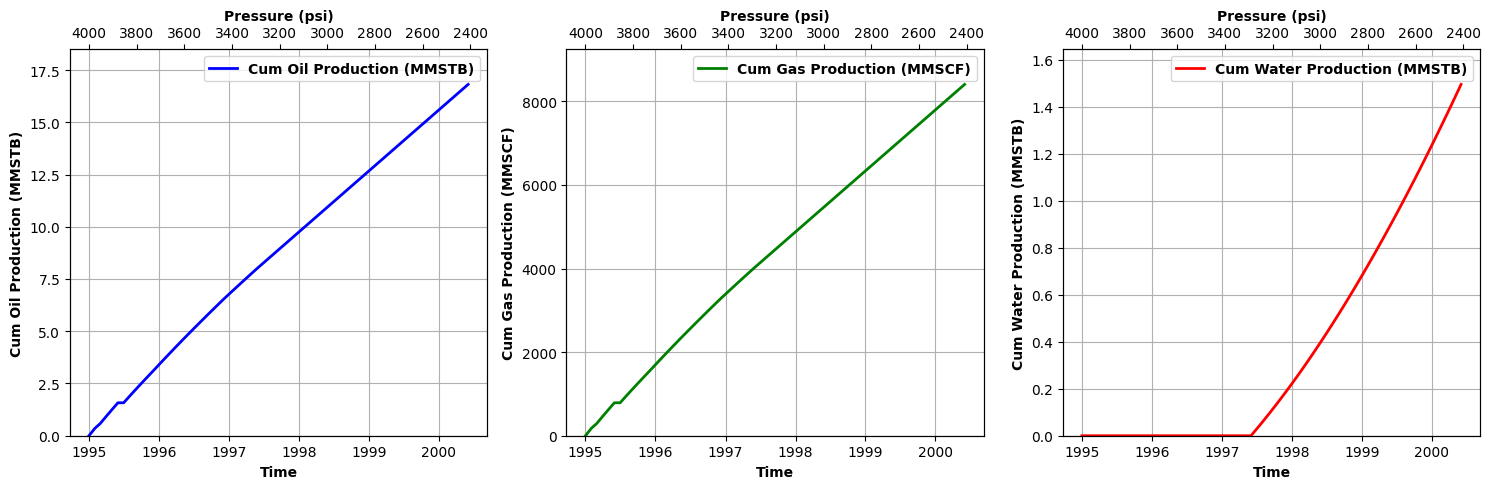

In [ ]:
# -----------------------------------------------------
# Load Production Data from Excel
# -----------------------------------------------------
history_data = pd.read_excel('oilres1.xls')
dates = pd.to_datetime(history_data['Date'])
pressure_data = history_data['Pressure'].values
Np_data = history_data['Cum Oil Production'].values
Gp_data = history_data['Cum Gas Production'].values
Wp_data = history_data['Cum Water Production'].values

n_points = len(pressure_data)

# Plot all production data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(dates, Np_data, 'b-', linewidth=2, label='Cum Oil Production (MMSTB)')
ax1.set_xlabel('Time', fontweight='bold')
ax1.set_ylabel('Cum Oil Production (MMSTB)', fontweight='bold')
ax1.set_ylim(min(Np_data) * 0.9, max(Np_data) * 1.1)
ax1.legend(prop={'weight':'bold'})
ax1.grid()
ax1_twin = ax1.twiny()
ax1_twin.plot(pressure_data, Np_data, 'r--', linewidth=2, alpha=0)
ax1_twin.set_xlabel('Pressure (psi)', fontweight='bold')
ax1_twin.invert_xaxis()

ax2.plot(dates, Gp_data, 'g-', linewidth=2, label='Cum Gas Production (MMSCF)')
ax2.set_xlabel('Time', fontweight='bold')
ax2.set_ylabel('Cum Gas Production (MMSCF)', fontweight='bold')
ax2.set_ylim(min(Gp_data) * 0.9, max(Gp_data) * 1.1)
ax2.legend(prop={'weight':'bold'})
ax2.grid()
ax2_twin = ax2.twiny()
ax2_twin.plot(pressure_data, Gp_data, 'r--', linewidth=2, alpha=0)
ax2_twin.set_xlabel('Pressure (psi)', fontweight='bold')
ax2_twin.invert_xaxis()

ax3.plot(dates, Wp_data, 'r-', linewidth=2, label='Cum Water Production (MMSTB)')
ax3.set_xlabel('Time', fontweight='bold')
ax3.set_ylabel('Cum Water Production (MMSTB)', fontweight='bold')
ax3.set_ylim(min(Wp_data) * 0.9, max(Wp_data) * 1.1)
ax3.legend(prop={'weight':'bold'})
ax3.grid()
ax3_twin = ax3.twiny()
ax3_twin.plot(pressure_data, Wp_data, 'r--', linewidth=2, alpha=0)
ax3_twin.set_xlabel('Pressure (psi)', fontweight='bold')
ax3_twin.invert_xaxis()

plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------
# Calculate Fluid Properties at Production Pressures
# -----------------------------------------------------

# Bubble Point Pressure (Pb) using Standing's Correlation
p_b = 18.2 * (((r_s_input / sg_g) ** 0.83) * (10 ** (0.00091 * t - (0.0125 * api))) - 1.4)
print(f"Calculated Bubble Point Pressure (Pb): {p_b:.2f} psi")

# Compute Rs (solution GOR) at each production pressure
Rs_data = np.zeros(n_points)
for i in range(n_points):
    if pressure_data[i] > p_b:
        Rs_data[i] = r_s_input
    else:
        Rs_data[i] = sg_g * (((pressure_data[i]+14.7) * (10 ** (0.0125 * api))) /(18 * (10 ** (0.00091 * t)))) ** 1.2048

# Calculate Oil Formation Volume Factor (Bo)
sg_o = 141.5 / (api + 131.5)
rs_bp = sg_g * ((p_b * (10 ** (0.0125 * api))) /(18 * (10 ** (0.00091 * t)))) ** 1.2048
bo_b = 0.9759 + 0.00012 * (((rs_bp * (sg_g / sg_o) ** 0.5) + (1.25 * t)) ** 1.2)

# Estimate oil compressibility (c_o)
c_o_data = np.zeros(n_points)
for i in range(n_points):
    c_o_data[i] = ((5 * rs_bp) + (17.2 * t) - (1180 * sg_g) + (12.61 * api) - 1433) / ((pressure_data[i]+14.7) * 100000)

Bo_data = np.zeros(n_points)
for i in range(n_points):
    if pressure_data[i] <= p_b:
        Bo_data[i] = 0.9759 + 0.00012 * (((Rs_data[i] * (sg_g / sg_o) ** 0.5) + (1.25 * t)) ** 1.2)
    else:
        Bo_data[i] = bo_b * np.exp(-c_o_data[i] * (pressure_data[i] - p_b))

# Compute Z Factor and Gas Formation Volume Factor (Bg)
Z_prod = np.array([compute_z(sg_g, p_val, t) for p_val in pressure_data])
Bg_data = 0.005035 * Z_prod * (t + 460) / pressure_data

# Compute Water Formation Volume Factor (Bw)
Bw_data = np.array([calculate_Bw(p_val, t) for p_val in pressure_data])

# Viscosity Calculation
v_od = 10 ** (10 ** (3.0324 - 0.02023 * api) * t ** (-1.163)) - 1
Viscosity_data = np.zeros(n_points)
for i in range(n_points):
    if pressure_data[i] <= p_b:
        Viscosity_data[i] = (10.715 * (Rs_data[i] + 100) ** (-0.515)) * v_od ** (5.44 * (Rs_data[i] + 150) ** (-0.338))
    else:
        v_o_sat = (10.715 * (rs_bp + 100) ** (-0.515)) * v_od ** (5.44 * (r_s_input + 150) ** (-0.338))
        Viscosity_data[i] = v_o_sat + 0.001 * (pressure_data[i] - p_b) * ((0.024 * v_o_sat ** 1.6) + (0.038 * v_o_sat ** 0.56))

# Initial conditions
B_oi = Bo_data[0]
R_si = Rs_data[0]
B_gi = Bg_data[0]

Calculated Bubble Point Pressure (Pb): 2071.31 psi


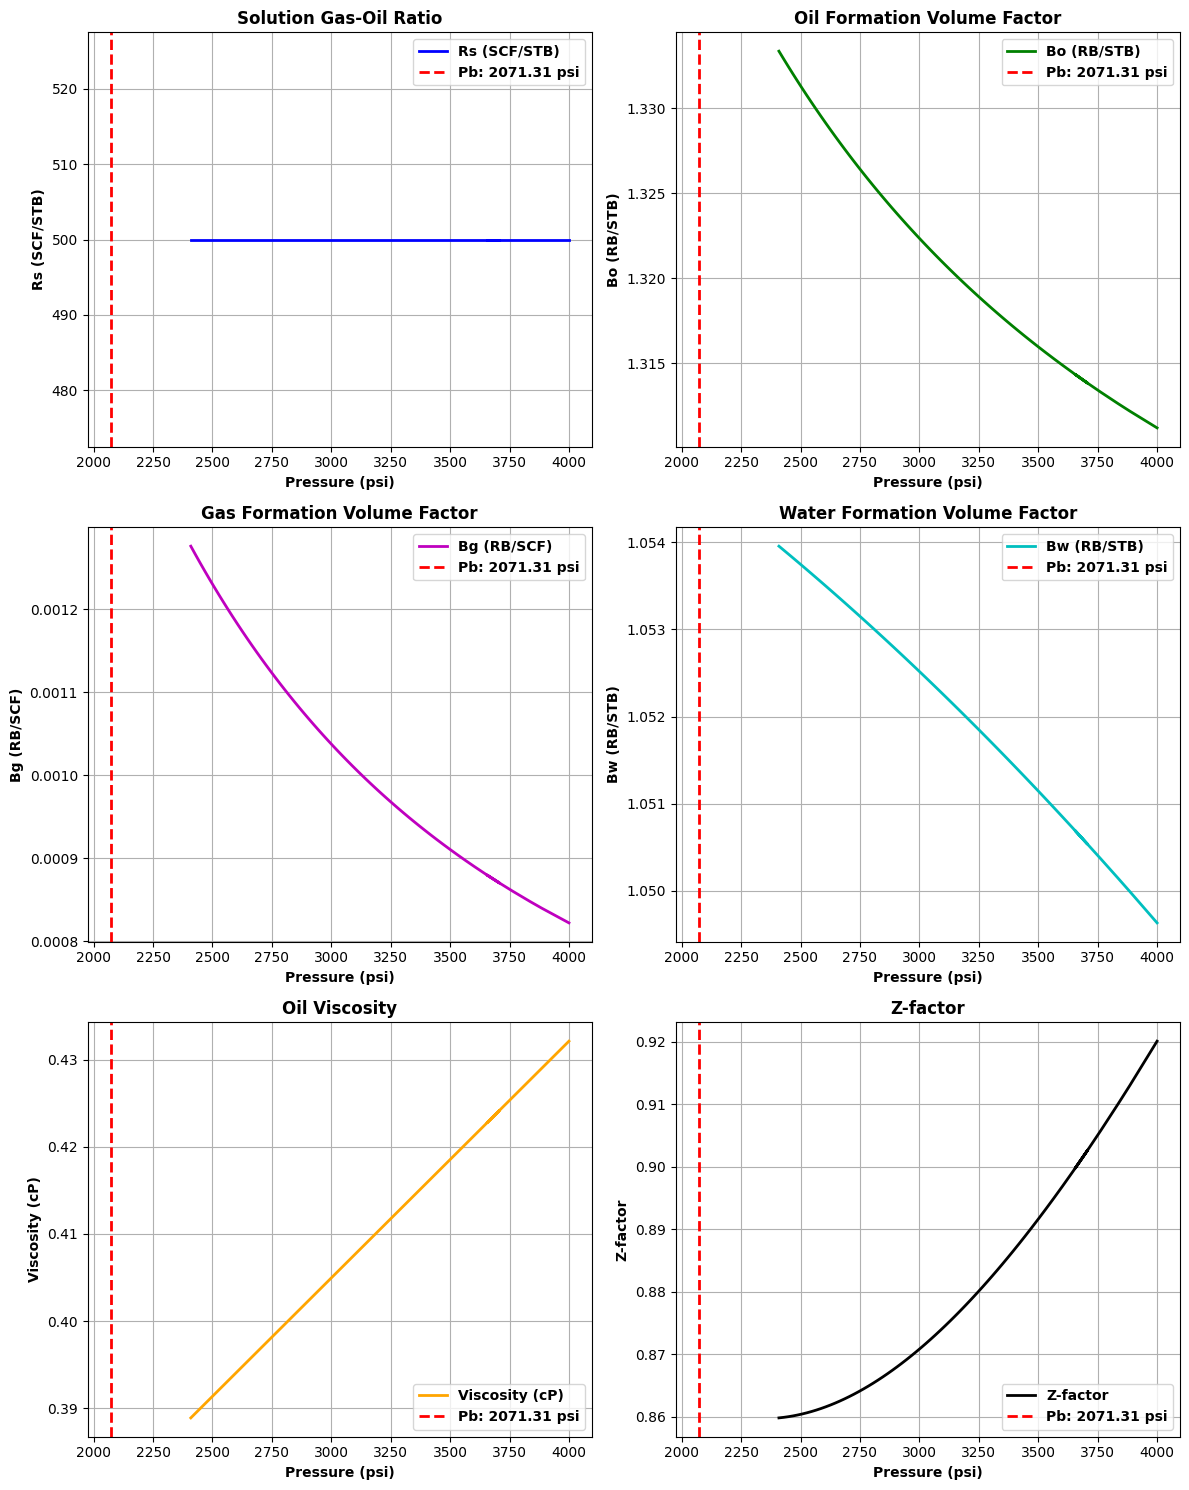

In [ ]:
# -----------------------------------------------------
# Fluid Properties Plots
# -----------------------------------------------------
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
ax[0, 0].plot(pressure_data, Rs_data, 'b-', linewidth=2, label='Rs (SCF/STB)')
ax[0, 0].axvline(p_b, color='r', linestyle='--', linewidth=2, label=f'Pb: {p_b:.2f} psi')
ax[0, 0].set_title('Solution Gas-Oil Ratio', fontweight='bold')
ax[0, 0].set_xlabel('Pressure (psi)', fontweight='bold')
ax[0, 0].set_ylabel('Rs (SCF/STB)', fontweight='bold')
ax[0, 0].legend(prop={'weight':'bold'})
ax[0, 0].grid()

ax[0, 1].plot(pressure_data, Bo_data, 'g-', linewidth=2, label='Bo (RB/STB)')
ax[0, 1].axvline(p_b, color='r', linestyle='--', linewidth=2, label=f'Pb: {p_b:.2f} psi')
ax[0, 1].set_title('Oil Formation Volume Factor', fontweight='bold')
ax[0, 1].set_xlabel('Pressure (psi)', fontweight='bold')
ax[0, 1].set_ylabel('Bo (RB/STB)', fontweight='bold')
ax[0, 1].legend(prop={'weight':'bold'})
ax[0, 1].grid()

ax[1, 0].plot(pressure_data, Bg_data, 'm-', linewidth=2, label='Bg (RB/SCF)')
ax[1, 0].axvline(p_b, color='r', linestyle='--', linewidth=2, label=f'Pb: {p_b:.2f} psi')
ax[1, 0].set_title('Gas Formation Volume Factor', fontweight='bold')
ax[1, 0].set_xlabel('Pressure (psi)', fontweight='bold')
ax[1, 0].set_ylabel('Bg (RB/SCF)', fontweight='bold')
ax[1, 0].legend(prop={'weight':'bold'})
ax[1, 0].grid()

ax[1, 1].plot(pressure_data, Bw_data, 'c-', linewidth=2, label='Bw (RB/STB)')
ax[1, 1].axvline(p_b, color='r', linestyle='--', linewidth=2, label=f'Pb: {p_b:.2f} psi')
ax[1, 1].set_title('Water Formation Volume Factor', fontweight='bold')
ax[1, 1].set_xlabel('Pressure (psi)', fontweight='bold')
ax[1, 1].set_ylabel('Bw (RB/STB)', fontweight='bold')
ax[1, 1].legend(prop={'weight':'bold'})
ax[1, 1].grid()

ax[2, 0].plot(pressure_data, Viscosity_data, 'orange', linewidth=2, label='Viscosity (cP)')
ax[2, 0].axvline(p_b, color='r', linestyle='--', linewidth=2, label=f'Pb: {p_b:.2f} psi')
ax[2, 0].set_title('Oil Viscosity', fontweight='bold')
ax[2, 0].set_xlabel('Pressure (psi)', fontweight='bold')
ax[2, 0].set_ylabel('Viscosity (cP)', fontweight='bold')
ax[2, 0].legend(prop={'weight':'bold'})
ax[2, 0].grid()

ax[2, 1].plot(pressure_data, Z_prod, 'k-', linewidth=2, label='Z-factor')
ax[2, 1].axvline(p_b, color='r', linestyle='--', linewidth=2, label=f'Pb: {p_b:.2f} psi')
ax[2, 1].set_title('Z-factor', fontweight='bold')
ax[2, 1].set_xlabel('Pressure (psi)', fontweight='bold')
ax[2, 1].set_ylabel('Z-factor', fontweight='bold')
ax[2, 1].legend(prop={'weight':'bold'})
ax[2, 1].grid()

plt.tight_layout()
plt.show()

<ipython-input-24-eaa196a3bb2b>:28: RuntimeWarning: invalid value encountered in divide
  F_over_Et = np.where(np.abs(E_t_data) > 1e-6, F_data / E_t_data, np.nan)


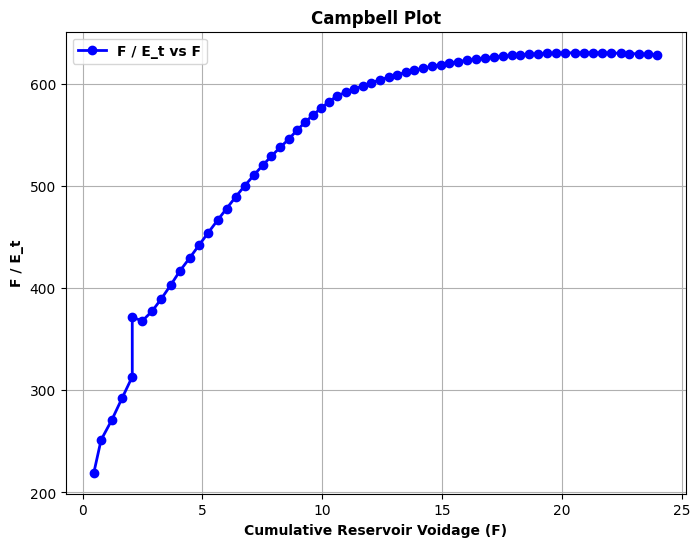

In [ ]:
# -----------------------------------------------------
# Campbell Plot Calculation
# -----------------------------------------------------
F_data = np.zeros(n_points)
for i in range(n_points):
    if pressure_data[i] < p_b:
        gas_term = (Gp_data[i] - Np_data[i] * Rs_data[i]) * Bg_data[i]
    else:
        gas_term = 0
    F_data[i] = Np_data[i] * Bo_data[i] + gas_term + Wp_data[i] * Bw_data[i]

c_e = (c_w * S_wc + c_f) / (1 - S_wc)
E_o_data = np.zeros(n_points)
E_g_data = np.zeros(n_points)
E_fw_data = np.zeros(n_points)
E_t_data = np.zeros(n_points)

for i in range(n_points):
    delta_p = res_p - pressure_data[i]
    if pressure_data[i] < p_b:
        E_o_data[i] = (Bo_data[i] - B_oi) + (R_si - Rs_data[i]) * Bg_data[i]
    else:
        E_o_data[i] = Bo_data[i] - B_oi
    E_g_data[i] = B_oi * (Bg_data[i] / B_gi - 1)
    E_fw_data[i] = (1 + m) * B_oi * c_e * delta_p
    E_t_data[i] = E_o_data[i] + m * E_g_data[i] + E_fw_data[i]

F_over_Et = np.where(np.abs(E_t_data) > 1e-6, F_data / E_t_data, np.nan)

plt.figure(figsize=(8, 6))
plt.plot(F_data, F_over_Et, 'bo-', linewidth=2, label='F / E_t vs F')
plt.xlabel('Cumulative Reservoir Voidage (F)', fontweight='bold')
plt.ylabel('F / E_t', fontweight='bold')
plt.title('Campbell Plot', fontweight='bold')
plt.legend(prop={'weight':'bold'})
plt.grid()
plt.show()

Is water influx present? (yes/no): yes
Enter Aquifer Volume (MMft^3):300


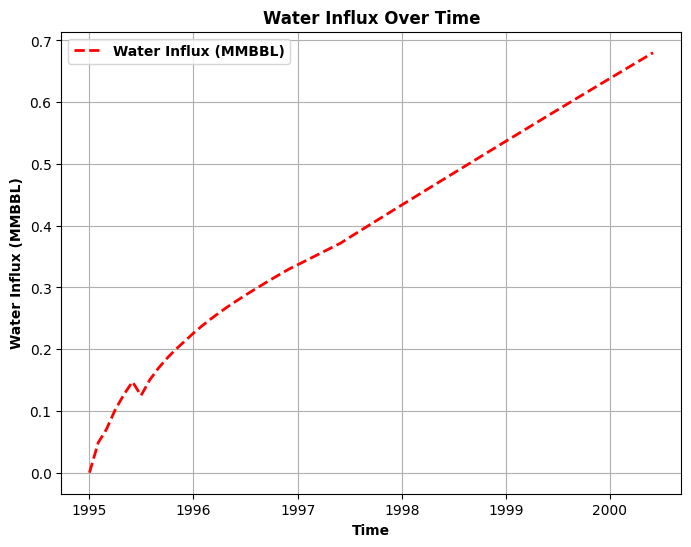

In [ ]:
# -----------------------------------------------------
# Calculate Water Influx using Pot Aquifer Method
# -----------------------------------------------------
influx_present = input("Is water influx present? (yes/no): ").strip().lower() == 'yes'
W_ei = float(input("Enter Aquifer Volume (MMft^3):"))

# Calculate Water Influx
c_t = c_w + c_f
We_data = np.zeros(n_points)
for i in range(n_points):
    delta_P = res_p - pressure_data[i]
    We_data[i] = (W_ei / 5.615) * c_t * delta_P

if influx_present:
    plt.figure(figsize=(8, 6))
    plt.plot(dates, We_data, 'r--', linewidth=2, label='Water Influx (MMBBL)')
    plt.xlabel('Time', fontweight='bold')
    plt.ylabel('Water Influx (MMBBL)', fontweight='bold')
    plt.title('Water Influx Over Time', fontweight='bold')
    plt.legend(prop={'weight':'bold'})
    plt.grid()
    plt.show()

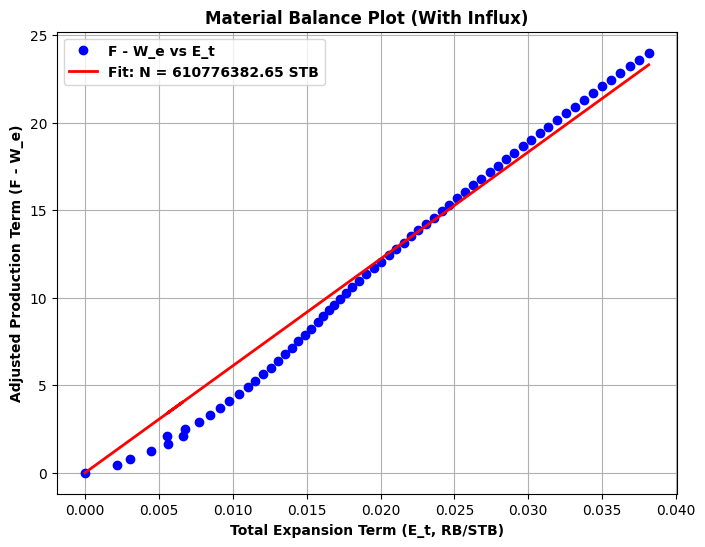

Estimated Original Oil in Place (Graphical with Water Influx): 610.78 MMSTB


In [ ]:
# -----------------------------------------------------
# Material Balance Plot for N Estimation
# -----------------------------------------------------
if not influx_present:
    num = np.sum(E_t_data * F_data)
    denom = np.sum(E_t_data**2)
    if denom == 0:
        raise ValueError("Zero variance in E_t_data")
    N_intercept = num / denom
    plt.figure(figsize=(8, 6))
    plt.plot(E_t_data, F_data, 'bo', linewidth=2, label='F vs E_t')
    plt.plot(E_t_data, N_intercept * E_t_data, 'r-', linewidth=2, label=f'Fit: N = {N_intercept * 1e6:.2f} STB')
    plt.xlabel('Total Expansion Term (E_t, RB/STB)', fontweight='bold')
    plt.ylabel('Production Term (F)', fontweight='bold')
    plt.title('Material Balance Plot (No Influx)', fontweight='bold')
    plt.legend(prop={'weight':'bold'})
    plt.grid()
    plt.show()
    print(f"Estimated Original Oil in Place (Graphical, No Influx): {N_intercept * 1e6:.2f} STB")
else:
    num = np.sum(E_t_data * (F_data - We_data / 1e6))
    denom = np.sum(E_t_data**2)
    if denom == 0:
        raise ValueError("Zero variance in E_t_data")
    N_intercept = num / denom
    F_minus_We = F_data - We_data / 1e6
    plt.figure(figsize=(8, 6))
    plt.plot(E_t_data, F_minus_We, 'bo', linewidth=2, label='F - W_e vs E_t')
    plt.plot(E_t_data, N_intercept * E_t_data, 'r-', linewidth=2, label=f'Fit: N = {N_intercept * 1e6:.2f} STB')
    plt.xlabel('Total Expansion Term (E_t, RB/STB)', fontweight='bold')
    plt.ylabel('Adjusted Production Term (F - W_e)', fontweight='bold')
    plt.title('Material Balance Plot (With Influx)', fontweight='bold')
    plt.legend(prop={'weight':'bold'})
    plt.grid()
    plt.show()
    print(f"Estimated Original Oil in Place (Graphical with Water Influx): {N_intercept :.2f} MMSTB")

<ipython-input-27-b463c5be4a8a>:22: RuntimeWarning: invalid value encountered in divide
  oil_gas_pct = (E_o_drive / total_expansion) * 100
<ipython-input-27-b463c5be4a8a>:23: RuntimeWarning: invalid value encountered in divide
  gas_cap_pct = (m * E_g_drive / total_expansion) * 100
<ipython-input-27-b463c5be4a8a>:24: RuntimeWarning: invalid value encountered in divide
  rock_water_pct = (E_fw_drive / total_expansion) * 100
<ipython-input-27-b463c5be4a8a>:25: RuntimeWarning: invalid value encountered in divide
  water_influx_pct = (We_term / total_expansion) * 100


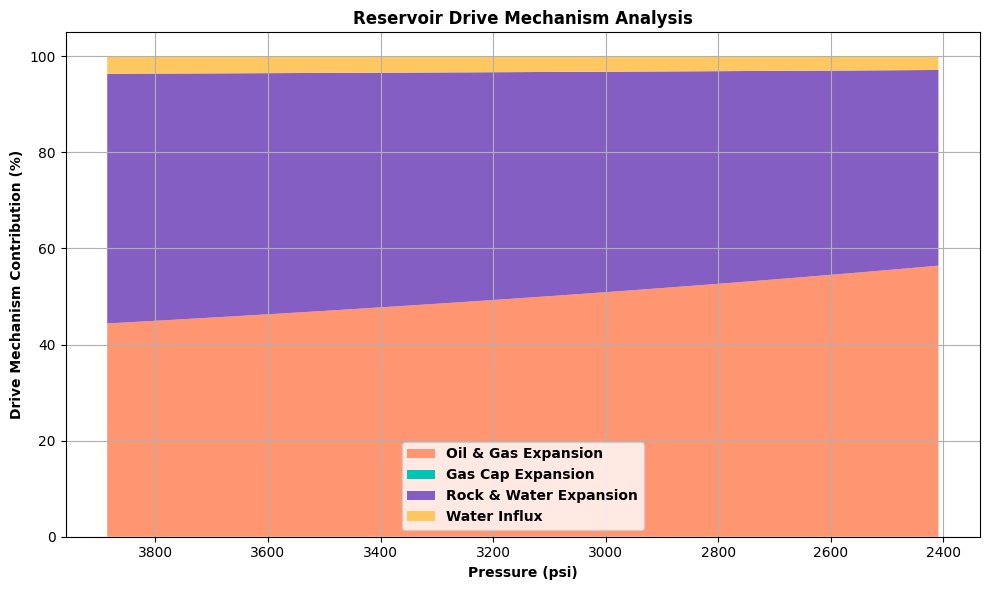

In [ ]:
# -----------------------------------------------------
# Drive Mechanism Analysis
# -----------------------------------------------------
E_o_drive = np.zeros(n_points)
E_g_drive = np.zeros(n_points)
E_fw_drive = np.zeros(n_points)
We_term = np.zeros(n_points)

for i in range(n_points):
    if pressure_data[i] < p_b:
        gas_expansion = (r_s_input - Rs_data[i]) * Bg_data[i]
    else:
        gas_expansion = 0
    E_o_drive[i] = (Bo_data[i] - B_oi) + gas_expansion
    E_g_drive[i] = B_oi * ((Bg_data[i] / B_gi) - 1)
    delta_p = res_p - pressure_data[i]
    E_fw_drive[i] = (1 + m) * B_oi * c_e * delta_p
    We_term[i] = We_data[i] / N_intercept

total_expansion = E_o_drive + m * E_g_drive + E_fw_drive + We_term

oil_gas_pct = (E_o_drive / total_expansion) * 100
gas_cap_pct = (m * E_g_drive / total_expansion) * 100
rock_water_pct = (E_fw_drive / total_expansion) * 100
water_influx_pct = (We_term / total_expansion) * 100

oil_gas_pct = np.nan_to_num(oil_gas_pct)
gas_cap_pct = np.nan_to_num(gas_cap_pct)
rock_water_pct = np.nan_to_num(rock_water_pct)
water_influx_pct = np.nan_to_num(water_influx_pct)

plot_pressure = pressure_data[1:]
plot_oil_pct = oil_gas_pct[1:]
plot_gas_pct = gas_cap_pct[1:]
plot_rock_pct = rock_water_pct[1:]
plot_water_pct = water_influx_pct[1:]

# -----------------------------
# Create a Stacked Plot of Drive Contributions
# ----------------------------
plt.figure(figsize=(10, 6))
plt.stackplot(plot_pressure, plot_oil_pct, plot_gas_pct, plot_rock_pct, plot_water_pct,
              labels=['Oil & Gas Expansion', 'Gas Cap Expansion', 'Rock & Water Expansion', 'Water Influx'],
              colors=['#FF9671', '#00C4B4', '#845EC2', '#FFC75F'], linewidth=2)
plt.xlabel('Pressure (psi)', fontweight='bold')
plt.ylabel('Drive Mechanism Contribution (%)', fontweight='bold')
plt.title('Reservoir Drive Mechanism Analysis', fontweight='bold')
plt.legend(prop={'weight':'bold'})
plt.grid(True)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

## **Future Prediction**

In [ ]:
# -----------------------------------------------------
# Future Prediction
# -----------------------------------------------------

# Step 1: Calculate average cumulative flow rates
# Convert historical cumulative productions from MMSTB/MMSCF to STB/SCF
Np_data_STB = Np_data * 1e6  # MMSTB -> STB
Gp_data_SCF = Gp_data * 1e6  # MMSCF -> SCF
Wp_data_STB = Wp_data * 1e6  # MMSTB -> STB

# Compute elapsed time (days) from the first historical date
time_days = (dates - dates.iloc[0]).dt.days

# Compute time differences between consecutive historical dates (in days)
time_diffs_days = np.diff(time_days)

# Compute average flow rates (STB/day for oil, SCF/day for gas)
q_o = np.diff(Np_data_STB) / time_diffs_days
q_g = np.diff(Gp_data_SCF) / time_diffs_days
q_w = np.diff(Wp_data_STB) / time_diffs_days

q_o_avg = np.mean(q_o)
q_g_avg = np.mean(q_g)
q_w_avg = np.mean(q_w)

print(f"Average Oil Flow Rate: {q_o_avg:.2f} STB/day")
print(f"Average Gas Flow Rate: {q_g_avg:.2f} SCF/day")
print(f"Average Water Flow Rate: {q_w_avg:.2f} STB/day")

Average Oil Flow Rate: 8494.61 STB/day
Average Gas Flow Rate: 4247315.63 SCF/day
Average Water Flow Rate: 755.79 STB/day


In [ ]:
# Step 2: Specify the future prediction date and generate a date range that begins with the last historical date.
future_date_str = input("Enter future date (YYYY-MM-DD): ")
future_date = pd.to_datetime(future_date_str)
last_date = dates.iloc[-1]
if future_date <= last_date:
    raise ValueError("Future date must be after the last historical date.")

# Here we generate monthly future dates (using month start 'MS')
# and force the first future date to be the same as the last historical date.
future_dates = pd.date_range(start=last_date, end=future_date, freq='MS')

# If the first generated date is not exactly the last historical date, prepend it.
if future_dates[0] != last_date:
    future_dates = np.insert(future_dates, 0, last_date)

# Calculate time differences (in days) relative to last_date.
# At the first future date, dt will be 0.
time_to_future_days = (future_dates - last_date).days

# Step 3: Calculate future cumulative productions
# N_intercept is the estimated OOIP in MMSTB (from the material balance plot)
N_MMSTB = N_intercept
N_STB = N_MMSTB * 1e6  # Convert OOIP to STB

Np_future = []
Gp_future = []
Wp_future = []
valid_future_dates = []

# Loop through each time difference dt.
for dt, f_date in zip(time_to_future_days, future_dates):
    # Forecast cumulative production by starting from the last historical value.
    Np_temp = Np_data_STB[-1] + q_o_avg * dt
    if Np_temp > N_STB:
        # Do not exceed the original oil in place.
        break
    Gp_temp = Gp_data_SCF[-1] + q_g_avg * dt
    Wp_temp = Wp_data_STB[-1] + q_w_avg * dt

    Np_future.append(Np_temp)
    Gp_future.append(Gp_temp)
    Wp_future.append(Wp_temp)
    valid_future_dates.append(f_date)

# Convert lists into NumPy arrays.
Np_future = np.array(Np_future)
Gp_future = np.array(Gp_future)
Wp_future = np.array(Wp_future)
future_dates = valid_future_dates

Enter future date (YYYY-MM-DD): 2010-01-01


In [ ]:
# Step 4 & 5: Back-calculate pressure and other fluid properties at the future production points.
# (The global variables like res_p, t, R_si, m, W_ei, c_t, etc. are assumed to be available.)
pressure_future = np.zeros(len(future_dates))
Bo_future = np.zeros(len(future_dates))
Rs_future = np.zeros(len(future_dates))
Bg_future = np.zeros(len(future_dates))
Bw_future = np.zeros(len(future_dates))
viscosity_future = np.zeros(len(future_dates))
Z_future = np.zeros(len(future_dates))

for i, (Np_val, Gp_val, Wp_val) in enumerate(zip(Np_future, Gp_future, Wp_future)):
    # Define the material balance function.
    # Use default keyword arguments to capture the current loop values.
    def f(p, Np=Np_val, Gp=Gp_val, Wp=Wp_val):
        Bo = calculate_Bo(p)
        Bg = calculate_Bg(p)
        Bw = calculate_Bw(p, t)
        # Production term:
        F = Np * Bo + (Gp - Np * R_si) * Bg + Wp * Bw
        # Expansion terms:
        E_o = calculate_E_o(p)
        E_g = calculate_E_g(p)
        E_fw = calculate_E_fw(p)
        E_t = E_o + m * E_g + E_fw
        # Water influx term (if applicable):
        W_e = (W_ei / 5.615) * c_t * (res_p - p) if influx_present else 0
        return F - N_STB * E_t - W_e

    # Solve for p using Brent's method within the interval [min_pressure, res_p].
    try:
        min_pressure = 1000  # Lower bound (adjust as needed)
        max_pressure = res_p
        pressure_future[i] = brentq(f, min_pressure, max_pressure, xtol=1e-6, maxiter=100)
    except ValueError:
        print(f"Warning: No solution found for date {future_dates[i]}. Using previous pressure value.")
        pressure_future[i] = pressure_future[i - 1] if i > 0 else pressure_data[-1]

# Recalculate future fluid properties at the solved pressures.
for i, p in enumerate(pressure_future):
    Bo_future[i] = calculate_Bo(p)
    Rs_future[i] = calculate_Rs(p)
    Bg_future[i] = calculate_Bg(p)
    Bw_future[i] = calculate_Bw(p, t)
    viscosity_future[i] = calculate_viscosity(p)
    Z_future[i] = compute_z(sg_g, p, t)

# Optionally, combine historical and future data for plotting:
all_dates = pd.to_datetime(np.append(dates, future_dates))
all_pressure = np.append(pressure_data, pressure_future)
all_Np = np.append(Np_data, Np_future / 1e6)  # Convert STB back to MMSTB
all_Gp = np.append(Gp_data, Gp_future / 1e6)  # Convert SCF back to MMSCF
all_Wp = np.append(Wp_data, Wp_future / 1e6)  # Convert STB back to MMSTB
all_Bo = np.append(Bo_data, Bo_future)
all_Rs = np.append(Rs_data, Rs_future)
all_Bg = np.append(Bg_data, Bg_future)
all_Bw = np.append(Bw_data, Bw_future)
all_viscosity = np.append(Viscosity_data, viscosity_future)
all_Z = np.append(Z_prod, Z_future)

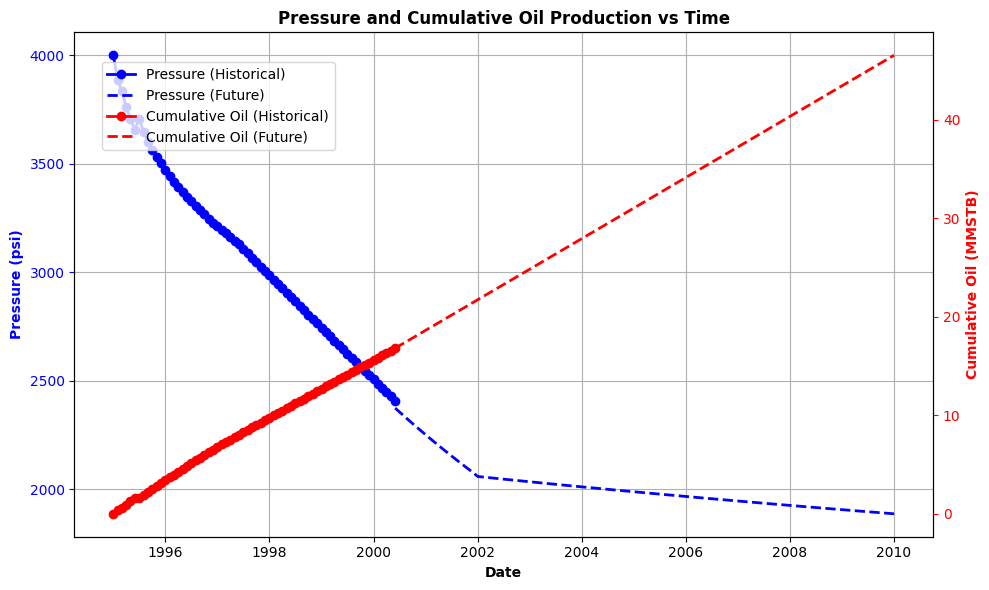

In [ ]:
# Plot Pressure and Cumulative Oil vs Time
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(all_dates[:len(dates)], all_pressure[:len(dates)], 'b-o', label='Pressure (Historical)', linewidth=2)
ax1.plot(future_dates, pressure_future, 'b--', label='Pressure (Future)', linewidth=2)
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('Pressure (psi)', color='b', fontweight='bold')
ax1.tick_params('y', colors='b')
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(all_dates[:len(dates)], all_Np[:len(dates)], 'r-o', label='Cumulative Oil (Historical)', linewidth=2)
ax2.plot(future_dates, all_Np[len(dates):], 'r--', label='Cumulative Oil (Future)', linewidth=2)
ax2.set_ylabel('Cumulative Oil (MMSTB)', color='r', fontweight='bold')
ax2.tick_params('y', colors='r')

plt.title('Pressure and Cumulative Oil Production vs Time', fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

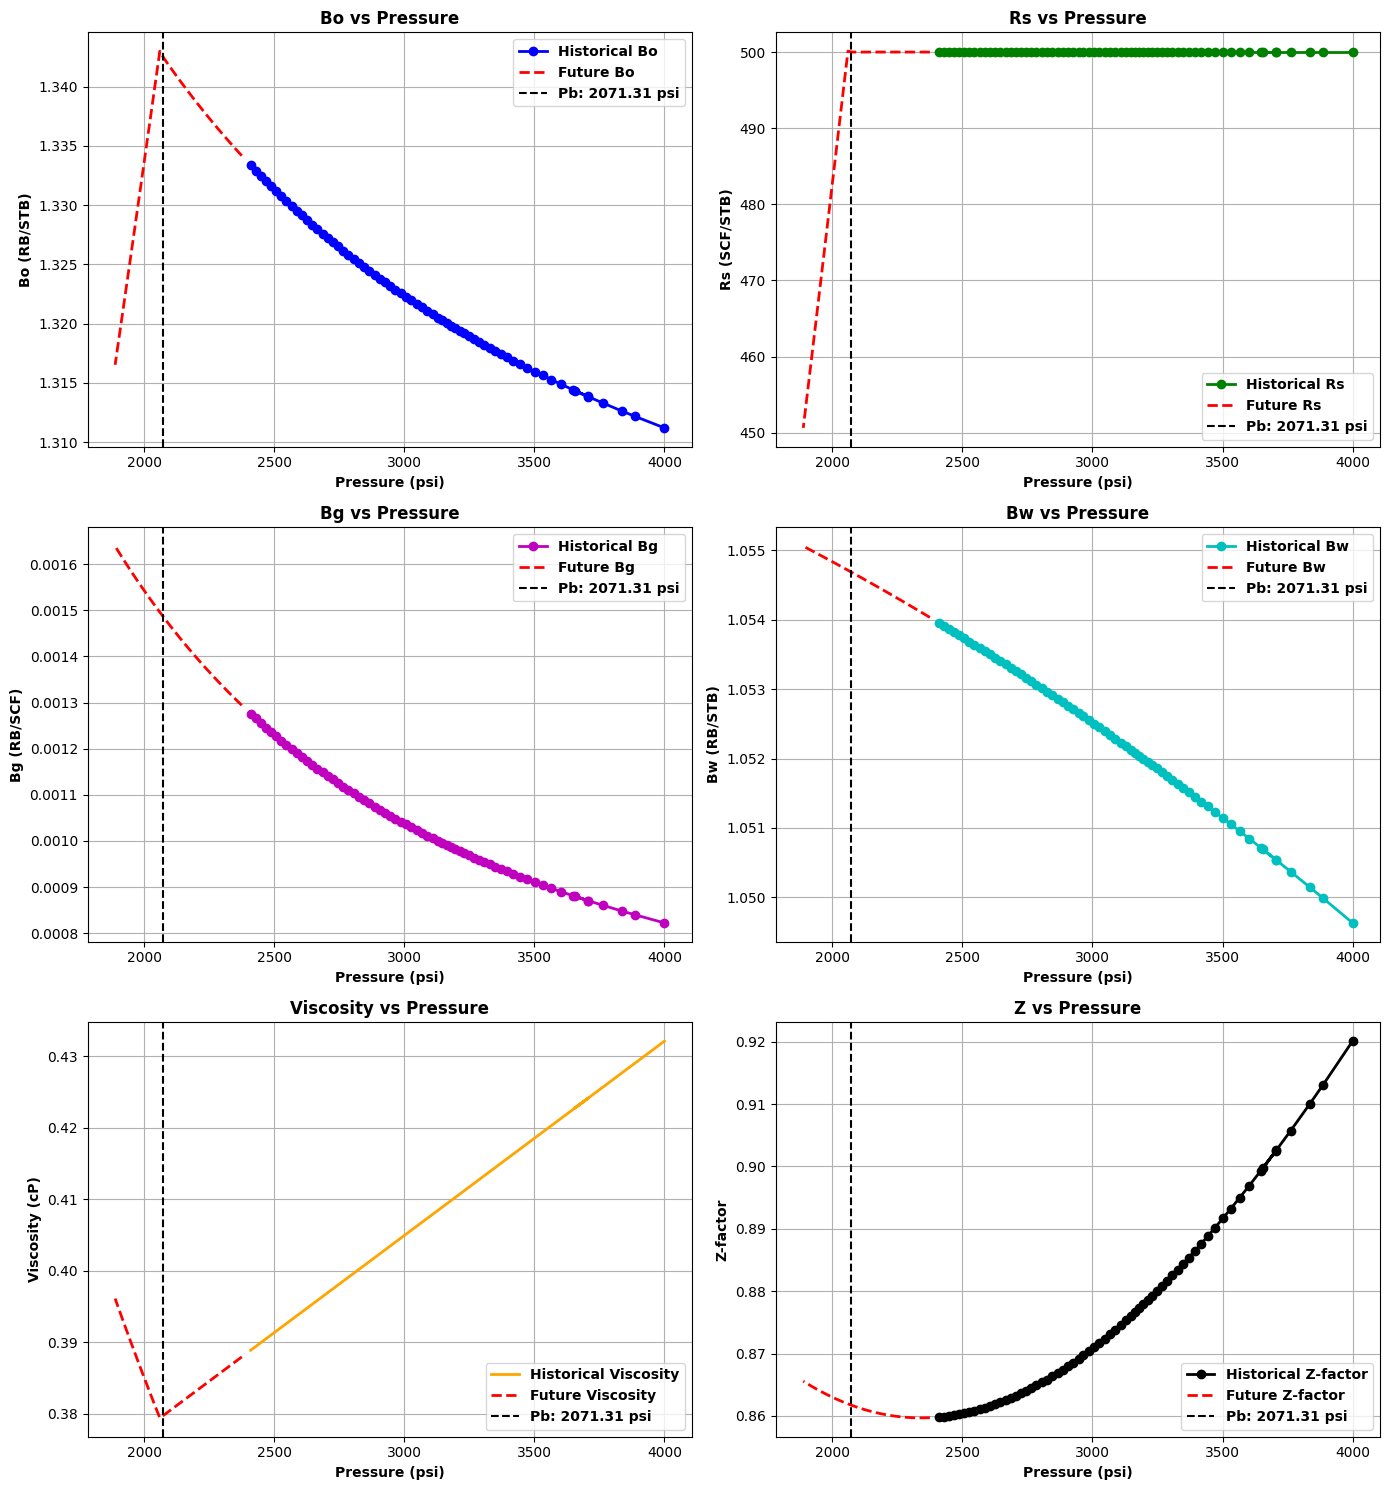

In [ ]:
# Plot Fluid Properties vs Pressure (Historical + Future)
fig, axs = plt.subplots(3, 2, figsize=(14, 15))
axs[0, 0].plot(all_pressure[:len(pressure_data)], all_Bo[:len(pressure_data)], 'b-o', label='Historical Bo', linewidth=2)
axs[0, 0].plot(all_pressure[len(pressure_data):], all_Bo[len(pressure_data):], 'r--', label='Future Bo', linewidth=2)
axs[0, 0].axvline(p_b, color='k', linestyle='--', label=f'Pb: {p_b:.2f} psi')
axs[0, 0].set_xlabel('Pressure (psi)', fontweight='bold')
axs[0, 0].set_ylabel('Bo (RB/STB)', fontweight='bold')
axs[0, 0].set_title('Bo vs Pressure', fontweight='bold')
axs[0, 0].legend(prop={'weight':'bold'})
axs[0, 0].grid()

axs[0, 1].plot(all_pressure[:len(pressure_data)], all_Rs[:len(pressure_data)], 'g-o', label='Historical Rs', linewidth=2)
axs[0, 1].plot(all_pressure[len(pressure_data):], all_Rs[len(pressure_data):], 'r--', label='Future Rs', linewidth=2)
axs[0, 1].axvline(p_b, color='k', linestyle='--', label=f'Pb: {p_b:.2f} psi')
axs[0, 1].set_xlabel('Pressure (psi)', fontweight='bold')
axs[0, 1].set_ylabel('Rs (SCF/STB)', fontweight='bold')
axs[0, 1].set_title('Rs vs Pressure', fontweight='bold')
axs[0, 1].legend(prop={'weight':'bold'})
axs[0, 1].grid()

axs[1, 0].plot(all_pressure[:len(pressure_data)], all_Bg[:len(pressure_data)], 'm-o', label='Historical Bg', linewidth=2)
axs[1, 0].plot(all_pressure[len(pressure_data):], all_Bg[len(pressure_data):], 'r--', label='Future Bg', linewidth=2)
axs[1, 0].axvline(p_b, color='k', linestyle='--', label=f'Pb: {p_b:.2f} psi')
axs[1, 0].set_xlabel('Pressure (psi)', fontweight='bold')
axs[1, 0].set_ylabel('Bg (RB/SCF)', fontweight='bold')
axs[1, 0].set_title('Bg vs Pressure', fontweight='bold')
axs[1, 0].legend(prop={'weight':'bold'})
axs[1, 0].grid()

axs[1, 1].plot(all_pressure[:len(pressure_data)], all_Bw[:len(pressure_data)], 'c-o', label='Historical Bw', linewidth=2)
axs[1, 1].plot(all_pressure[len(pressure_data):], all_Bw[len(pressure_data):], 'r--', label='Future Bw', linewidth=2)
axs[1, 1].axvline(p_b, color='k', linestyle='--', label=f'Pb: {p_b:.2f} psi')
axs[1, 1].set_xlabel('Pressure (psi)', fontweight='bold')
axs[1, 1].set_ylabel('Bw (RB/STB)', fontweight='bold')
axs[1, 1].set_title('Bw vs Pressure', fontweight='bold')
axs[1, 1].legend(prop={'weight':'bold'})
axs[1, 1].grid()

axs[2, 0].plot(all_pressure[:len(pressure_data)], all_viscosity[:len(pressure_data)], 'orange', label='Historical Viscosity', linewidth=2)
axs[2, 0].plot(all_pressure[len(pressure_data):], all_viscosity[len(pressure_data):], 'r--', label='Future Viscosity', linewidth=2)
axs[2, 0].axvline(p_b, color='k', linestyle='--', label=f'Pb: {p_b:.2f} psi')
axs[2, 0].set_xlabel('Pressure (psi)', fontweight='bold')
axs[2, 0].set_ylabel('Viscosity (cP)', fontweight='bold')
axs[2, 0].set_title('Viscosity vs Pressure', fontweight='bold')
axs[2, 0].legend(prop={'weight':'bold'})
axs[2, 0].grid()

axs[2, 1].plot(all_pressure[:len(pressure_data)], all_Z[:len(pressure_data)], 'k-o', label='Historical Z-factor', linewidth=2)
axs[2, 1].plot(all_pressure[len(pressure_data):], all_Z[len(pressure_data):], 'r--', label='Future Z-factor', linewidth=2)
axs[2, 1].axvline(p_b, color='k', linestyle='--', label=f'Pb: {p_b:.2f} psi')
axs[2, 1].set_xlabel('Pressure (psi)', fontweight='bold')
axs[2, 1].set_ylabel('Z-factor', fontweight='bold')
axs[2, 1].set_title('Z vs Pressure', fontweight='bold')
axs[2, 1].legend(prop={'weight':'bold'})
axs[2, 1].grid()

plt.tight_layout()
plt.show()

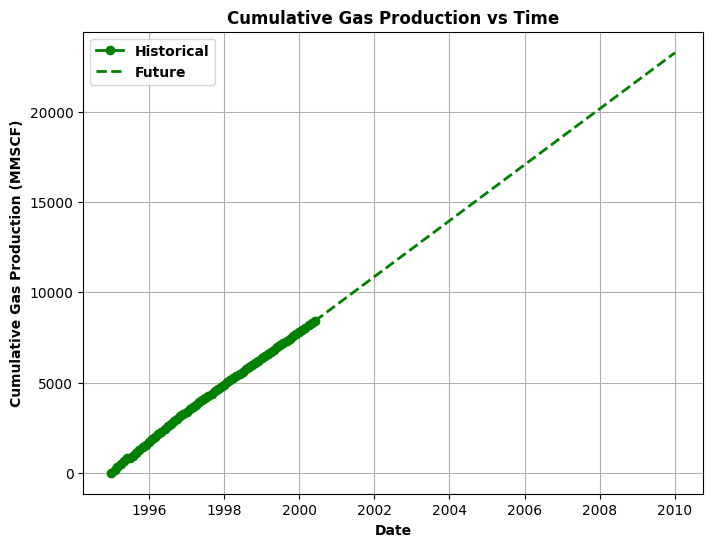

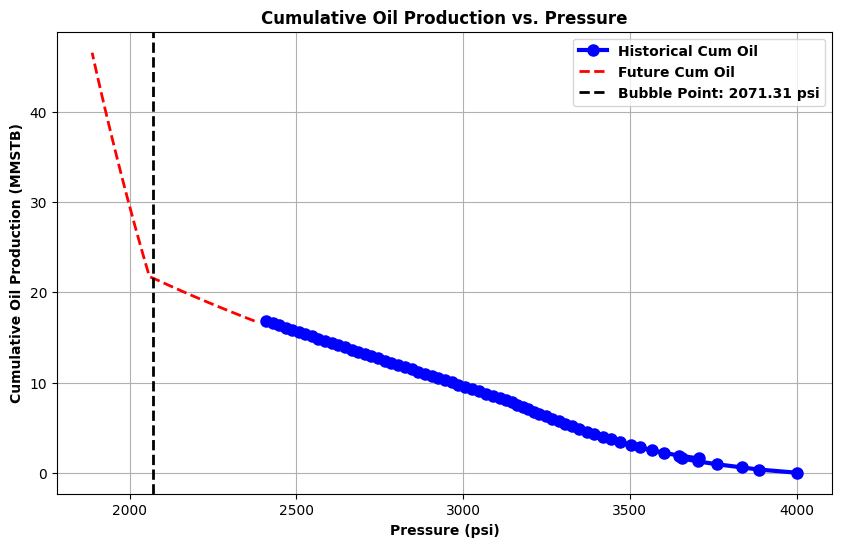

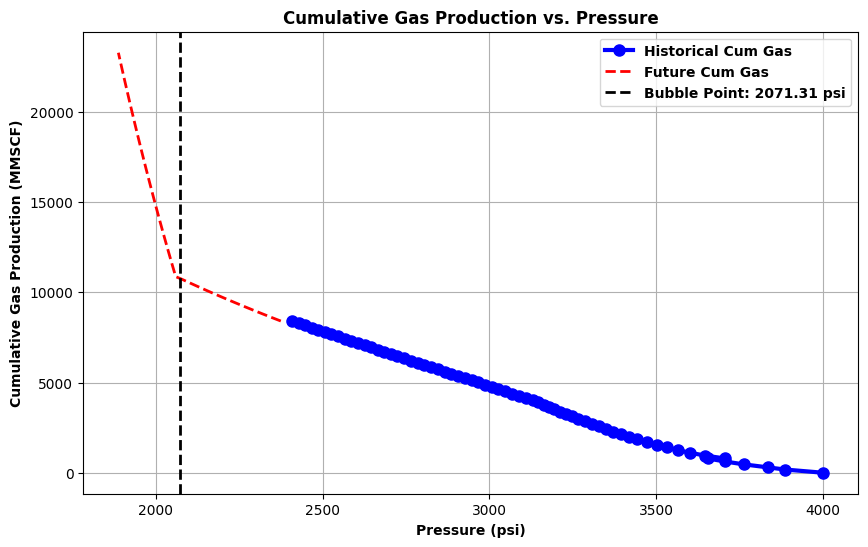

In [ ]:
# Plot Cumulative Gas Production vs Time
plt.figure(figsize=(8, 6))
plt.plot(all_dates[:len(dates)], all_Gp[:len(dates)], 'g-o', label='Historical', linewidth=2)
plt.plot(future_dates, all_Gp[len(dates):], 'g--', label='Future', linewidth=2)
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Cumulative Gas Production (MMSCF)', fontweight='bold')
plt.title('Cumulative Gas Production vs Time', fontweight='bold')
plt.legend(prop={'weight':'bold'})
plt.grid()
plt.show()

# Pressure vs. Cumulative Oil Production
plt.figure(figsize=(10,6))
plt.plot(pressure_data, Np_data, 'b-o', linewidth=3, markersize=8, label='Historical Cum Oil')
plt.plot(pressure_future, all_Np[len(dates):], 'r--', linewidth=2, markersize=8, label='Future Cum Oil')
plt.axvline(p_b, color='k', linestyle='--', linewidth=2, label=f'Bubble Point: {p_b:.2f} psi')
plt.xlabel('Pressure (psi)', fontweight='bold')
plt.ylabel('Cumulative Oil Production (MMSTB)', fontweight='bold')
plt.title('Cumulative Oil Production vs. Pressure', fontweight='bold')
plt.legend(prop={'weight':'bold'})
plt.grid(True)
plt.show()

# Pressure vs. Cumulative Gas Production
plt.figure(figsize=(10,6))
plt.plot(pressure_data, Gp_data, 'b-o', linewidth=3, markersize=8, label='Historical Cum Gas')
plt.plot(pressure_future, all_Gp[len(dates):], 'r--', linewidth=2, markersize=8, label='Future Cum Gas')
plt.axvline(p_b, color='k', linestyle='--', linewidth=2, label=f'Bubble Point: {p_b:.2f} psi')
plt.xlabel('Pressure (psi)', fontweight='bold')
plt.ylabel('Cumulative Gas Production (MMSCF)', fontweight='bold')
plt.title('Cumulative Gas Production vs. Pressure', fontweight='bold')
plt.legend(prop={'weight':'bold'})
plt.grid(True)
plt.show()

In [ ]:
# -----------------------------------------------------
# Save All Calculated Data to CSV
# -----------------------------------------------------
final_output = pd.DataFrame({
    'Date': all_dates,
    'Pressure (psi)': all_pressure,
    'Cum Oil Production (MMSTB)': all_Np,
    'Cum Gas Production (MMSCF)': all_Gp,
    'Cum Water Production (MMSTB)': all_Wp,
    'Bo (RB/STB)': all_Bo,
    'Rs (SCF/STB)': all_Rs,
    'Bg (RB/SCF)': all_Bg,
    'Bw (RB/STB)': all_Bw,
    'Viscosity (cP)': all_viscosity,
    'Z-factor': all_Z
})
final_output.to_csv('oil_material_balance_with_future.csv', index=False)
print("All calculated terms including future prediction saved to 'oil_material_balance_with_future.csv'.")

All calculated terms including future prediction saved to 'oil_material_balance_with_future.csv'.
